# Single cell proteogenomic analysis of the cell cycle

## Protein cell cycle clusters
Analysis of protein abundance by cell cycle phase.
-  Uses Gaussian clustering to group cell expression into cell cycle phases.
-  This is referred to as the "mock-bulk" analysis in the paper.

In [14]:
#%% Imports
from SingleCellProteogenomics.utils import *
import SingleCellProteogenomics.utils as utils
import SingleCellProteogenomics.Loaders as Loaders
import SingleCellProteogenomics.ProteinDataPreparation as ProteinDataPreparation
import SingleCellProteogenomics.ProteinGaussianClustering as ProteinGaussianClustering
import SingleCellProteogenomics.ProteinVariability as ProteinVariability
import SingleCellProteogenomics.ProteinBimodality as ProteinBimodality
import SingleCellProteogenomics.ProteinCellCycleDependence as ProteinCellCycleDependence
import SingleCellProteogenomics.FucciPseudotime as FucciPseudotime
import SingleCellProteogenomics.FucciCellCycle as FucciCellCycle
import SingleCellProteogenomics.RNADataPreparation as RNADataPreparation
import SingleCellProteogenomics.RNACellCycleDependence as RNACellCycleDependence
import SingleCellProteogenomics.TemporalDelay as TemporalDelay
import SingleCellProteogenomics.PTMAnalysis as PTMAnalysis
import SingleCellProteogenomics.ProteinStabilityAnalysis as ProteinStabilityAnalysis
plt.rcParams['pdf.fonttype'], plt.rcParams['ps.fonttype'], plt.rcParams['savefig.dpi'] = 42, 42, 300 #Make PDF text readable

# Object representing the lengths of the cell cycle phases in FUCCI cells
fucci = FucciCellCycle.FucciCellCycle()

In [2]:
#%% Read in the protein data (methods in ProteinDataPreparation.py)
my_df = ProteinDataPreparation.read_raw_data()
plate, u_plate, well_plate, well_plate_imgnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment = ProteinDataPreparation.read_sample_info(my_df)
wp_ensg, wp_ab, wp_prev_ccd, wp_prev_notccd, wp_prev_negative, prev_ccd_ensg, prev_notccd_ensg, prev_negative_ensg = ProteinDataPreparation.previous_results(u_well_plates, result_dict, ensg_dict, ab_dict)


reading raw protein IF data
loaded raw data


637104: number of cells before filtering empty wells
636296: number of cells after filtering empty wells
filtering out of focus
636296: number of cells before filtering out of focus images
629997: number of cells after filtering out of focus images
finished filtering
filtering negative staining
629997: number of cells before filtering negative staining from first batch
590511: number of cells after filtering negative staining from first batch
finished filtering
filtering bad fields of view (negative staining, unspecific, etc)
590511: number of cells before filtering out of focus images
521702: number of cells after filtering out of focus images
finished filtering
filtering failed antibodies
521702: number of cells before filtering antibodies failed in HPAv19
505930: number of cells after filtering antibodies failed in HPAv19
finished filtering
filtering mitotic proteins
505930: number of cells before filtering mitotic/microtubule proteins
505335: number of cells after filtering mitotic

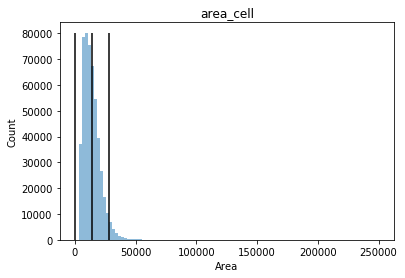

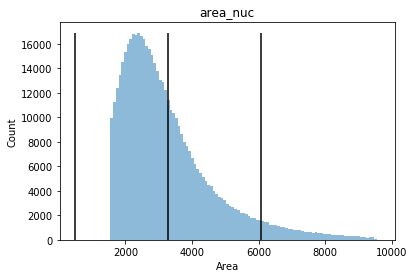

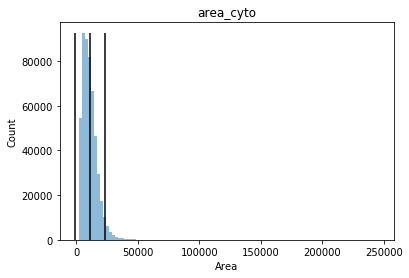

filtering super big nuclei
505335: number of cells before filtering out super big nuclei
477855: number of cells after filtering out super big nuclei
finished filtering on nuclei


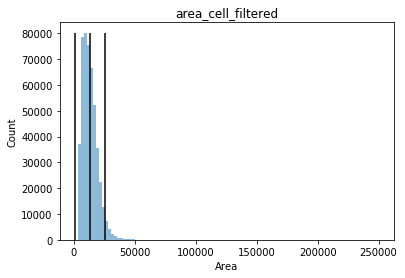

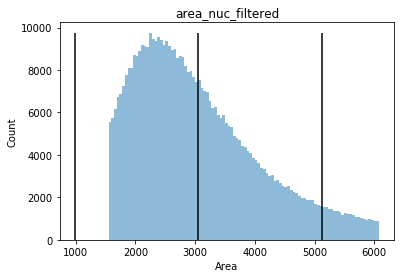

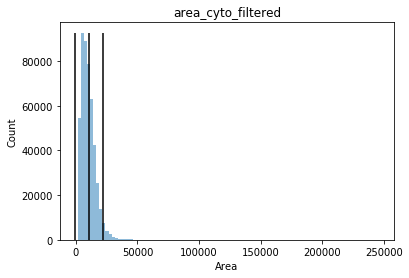

filtering low cell counts
477855: number of cells before filtering out samples with < 60 cells
477118: number of cells after filtering out samples with < 60 cells
finished filtering on cell count


In [3]:
#%% Idea: Filter the raw data (methods in ProteinDataPreparation.py)
# Execution: Use manual annotations and nucleus size to filter samples and images
# Output: Filtered dataframe
my_df_filtered = ProteinDataPreparation.apply_manual_filtering(my_df, result_dict, ab_dict)
my_df_filtered = ProteinDataPreparation.apply_big_nucleus_filter(my_df_filtered)
my_df_filtered = ProteinDataPreparation.apply_cell_count_filter(my_df_filtered)
my_df_filtered.to_csv("input/processed/python/nuc_predicted_prob_phases_filtered.csv")
plate, u_plate, well_plate, well_plate_imgnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment = ProteinDataPreparation.read_sample_info(my_df_filtered)
wp_ensg, wp_ab, wp_prev_ccd, wp_prev_notccd, wp_prev_negative, prev_ccd_ensg, prev_notccd_ensg, prev_negative_ensg = ProteinDataPreparation.previous_results(u_well_plates, result_dict, ensg_dict, ab_dict)


In [4]:
#%% Idea: Filter for variation and get compartments (methods in ProteinDataPreparation.py)
# Execution: Use annotated variation and compartment information
# Output: Number of cells filtered
my_df_filtered_variation, my_df_filtered_novariation = ProteinDataPreparation.apply_variation_filter(my_df_filtered, result_dict, my_df)

## Uncomment to output these dataframes (used for skewness / kurtosis analysis)
# my_df_filtered_variation.to_csv("output/nuc_predicted_prob_phases_filtered_variation.csv")
# my_df_filtered_novariation.to_csv("output/nuc_predicted_prob_phases_filtered_novariation.csv")

# filter out the ones missing compartment information; these are localized to mitotic structures and handled differently
plate, u_plate, well_plate, well_plate_imgnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment = ProteinDataPreparation.read_sample_info(my_df_filtered_variation)
wp_iscell, wp_isnuc, wp_iscyto, my_df_filtered_compartmentvariation = ProteinDataPreparation.metacompartments(u_well_plates, compartment_dict, my_df_filtered_variation)

# demonstrate that there are no more missing compartment information
plate, u_plate, well_plate, well_plate_imgnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment = ProteinDataPreparation.read_sample_info(my_df_filtered_compartmentvariation)
wp_iscell, wp_isnuc, wp_iscyto, my_df_filtered_compartmentvariation = ProteinDataPreparation.metacompartments(u_well_plates, compartment_dict, my_df_filtered_compartmentvariation)
wp_ensg, wp_ab, wp_prev_ccd, wp_prev_notccd, wp_prev_negative, prev_ccd_ensg, prev_notccd_ensg, prev_negative_ensg = ProteinDataPreparation.previous_results(u_well_plates, result_dict, ensg_dict, ab_dict)


637104: number of cells before filtering for variation
276856: number of cells in samples with variation
200262: number of cells in samples without variation
14: samples without compartment information; to be filtered since they're biologically defined as CCD and not included in the analysis
276856: number of cells before filtering for compartment information
273709: number of cells before filtering for compartment information
0: samples without compartment information; to be filtered since they're biologically defined as CCD and not included in the analysis
273709: number of cells before filtering for compartment information
273709: number of cells before filtering for compartment information


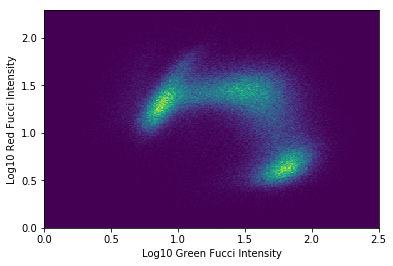

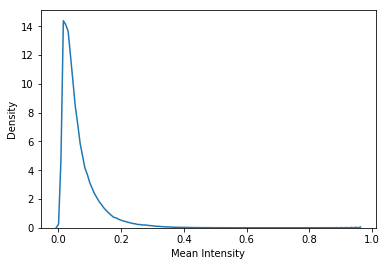

In [5]:
#%% Idea: Get and process intensities (methods in ProteinDataPreparation.py and ProteinGaussianClustering.py)
# Execution: get intensities; zero center fucci intensities
# Output: Fucci plot
ab_nuc, ab_cyto, ab_cell, mt_cell, green_fucci, red_fucci = ProteinDataPreparation.read_sample_data(my_df_filtered_compartmentvariation)
log_green_fucci, log_red_fucci, log_green_fucci_zeroc, log_red_fucci_zeroc, log_green_fucci_zeroc_rescale, log_red_fucci_zeroc_rescale, fucci_data = ProteinGaussianClustering.zero_center_fucci(green_fucci, red_fucci, u_plate, well_plate, plate)
    
plt.hist2d(log_green_fucci_zeroc_rescale,log_red_fucci_zeroc_rescale,bins=200)
plt.xlabel("Log10 Green Fucci Intensity")
plt.ylabel("Log10 Red Fucci Intensity")
plt.savefig("figures/FucciPlotProteinIFData_unfiltered.png")
plt.show()
plt.close()

# General picture of antibody intensity density
sbn.distplot(ab_cell, hist=False)
plt.xlabel("Mean Intensity")
plt.ylabel("Density")
plt.savefig("figures/antibody_cell_intensity.pdf")
plt.show()
plt.close()


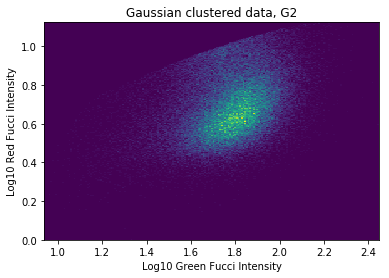

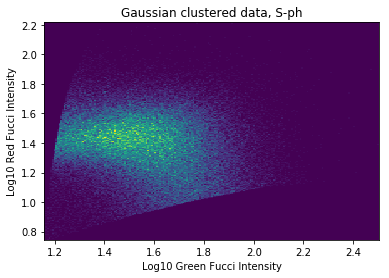

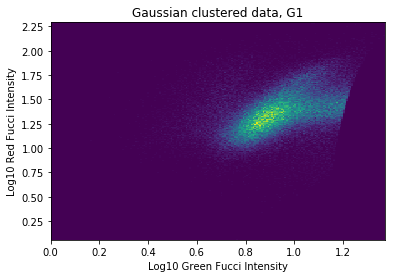

1253: number of genes tested
491: number of passing genes at 5.0% FDR in compartment
469: number of passing genes at 5.0% FDR in compartment (no replicate)
5: number of CCD genes shown to be CCD in both replicates
12: number of CCD genes shown to be CCD in just one replicate
17: number of CCD genes shown to be non-CCD in both replicate
469: number of passing antibodies at 5.0% FDR in compartment (no replicate)
5: number of duplicated antibodies shown to be CCD in both replicates
12: number of duplicated antibodies shown to be CCD in just one replicate
17: number of duplicated antibodies shown to be non-CCD in both replicate


In [6]:
#%% Idea: Gaussian clustering per plate to identify G1/S/G2 and do kruskal test for variance
# Exec: sklearn.mixture.GaussianMixture & scipy.stats.kruskal
# Output: FDR for cell cycle variation per well per compartment
cluster_labels = ProteinGaussianClustering.gaussian_clustering(log_green_fucci_zeroc_rescale, log_red_fucci_zeroc_rescale)

# NB! The cluster labels can change if any prior analysis changes. Inspect the plots so that top-left FUCCI cluster is G1, top-right is S, bottom-right is G2.
g1, sph, g2 = cluster_labels == 2, cluster_labels == 1, cluster_labels == 0
alpha_gauss, doGenerateBoxplotsPerGene = 0.05, True
wp_comp_kruskal_gaussccd_adj, wp_pass_kruskal_gaussccd_bh_comp, wp_mt_kruskal_gaussccd_adj, wp_pass_gaussccd_bh_mt =  ProteinGaussianClustering.gaussian_clustering_analysis(alpha_gauss, doGenerateBoxplotsPerGene, g1, sph, g2, wp_ensg, well_plate, u_well_plates, ab_cell, ab_nuc, ab_cyto, mt_cell, wp_iscell, wp_isnuc, wp_iscyto)

# General look at replicates in mock-bulk analysis
ProteinGaussianClustering.address_replicates(alpha_gauss, wp_pass_kruskal_gaussccd_bh_comp, wp_ensg, wp_ab, u_well_plates)

 ## Protein FUCCI pseudotime
 Analysis of protein abundance in individual cells over cell division time.
-  Cell division time is measured with FUCCI markers and modeled in log-log space using polar coordinates.
-  The cell division time modeling is referred to as the "pseudotime" analysis in the paper.
-  Protein abundance is measured in individual asynchronous cells using immunofluorescence and antibody staining.

In [7]:
#%% Read in the protein data
import_dict = Loaders.load_protein_fucci_pseudotime()
u_plate, well_plate, well_plate_imgnb, u_well_plates = import_dict["u_plate"], import_dict["well_plate"], import_dict["well_plate_imgnb"], import_dict["u_well_plates"]
ab_nuc, ab_cyto, ab_cell, mt_cell = import_dict["ab_nuc"], import_dict["ab_cyto"], import_dict["ab_cell"], import_dict["mt_cell"]
area_cell, area_nuc =  import_dict["area_cell"], import_dict["area_nuc"]
wp_ensg, wp_ab = import_dict["wp_ensg"], import_dict["wp_ab"]
green_fucci, red_fucci = import_dict["green_fucci"], import_dict["red_fucci"]
log_green_fucci_zeroc, log_red_fucci_zeroc = import_dict["log_green_fucci_zeroc"], import_dict["log_red_fucci_zeroc"]
log_green_fucci_zeroc_rescale, log_red_fucci_zeroc_rescale = import_dict["log_green_fucci_zeroc_rescale"], import_dict["log_red_fucci_zeroc_rescale"]
wp_comp_kruskal_gaussccd_adj, wp_pass_kruskal_gaussccd_bh_comp = import_dict["wp_comp_kruskal_gaussccd_adj"], import_dict["wp_pass_kruskal_gaussccd_bh_comp"]
fucci_data = import_dict["fucci_data"]
wp_iscell, wp_isnuc, wp_iscyto = import_dict["wp_iscell"], import_dict["wp_isnuc"], import_dict["wp_iscyto"]

[1.41692701 1.19758427]
[1.41692704 1.19758427]
[1.41692701 1.19758429]
[1.35131348 1.0463106 ]
[1.3513135 1.0463106]
[1.35131348 1.04631062]
[1.31856855 0.99282078]
[1.31856857 0.99282078]
[1.31856855 0.9928208 ]
[1.30931572 0.97916186]
[1.30931574 0.97916186]
[1.30931572 0.97916188]
[1.30722    0.97617003]
[1.30722002 0.97617003]
[1.30722    0.97617004]
[1.30678002 0.97554874]
[1.30678004 0.97554874]
[1.30678002 0.97554876]
[1.30668871 0.97542102]
[1.30668873 0.97542102]
[1.30668871 0.97542103]
[1.30666983 0.97539475]
[1.30666985 0.97539475]
[1.30666983 0.97539477]
[1.30666593 0.97538935]
[1.30666595 0.97538935]
[1.30666593 0.97538937]


C:\Users\antho\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


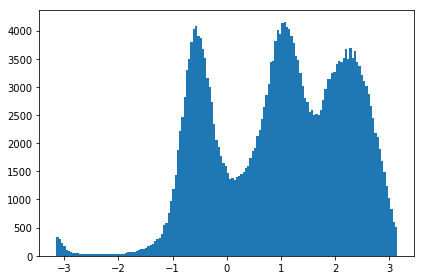

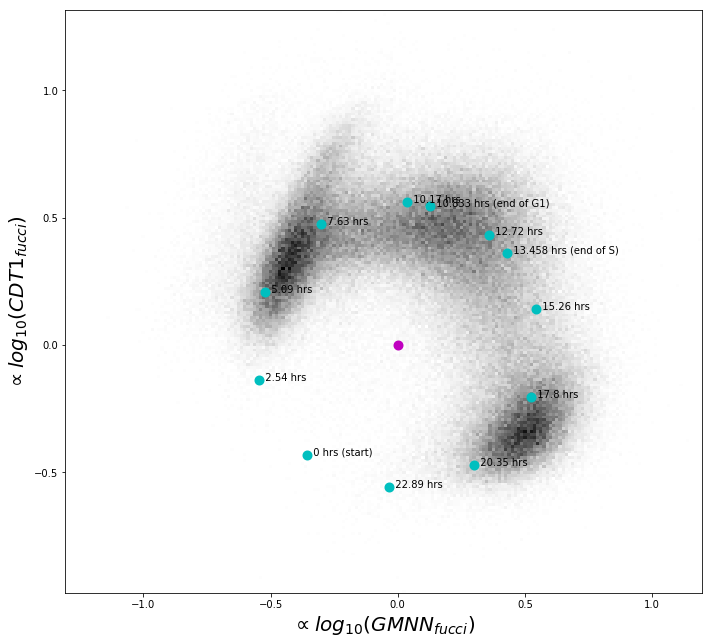

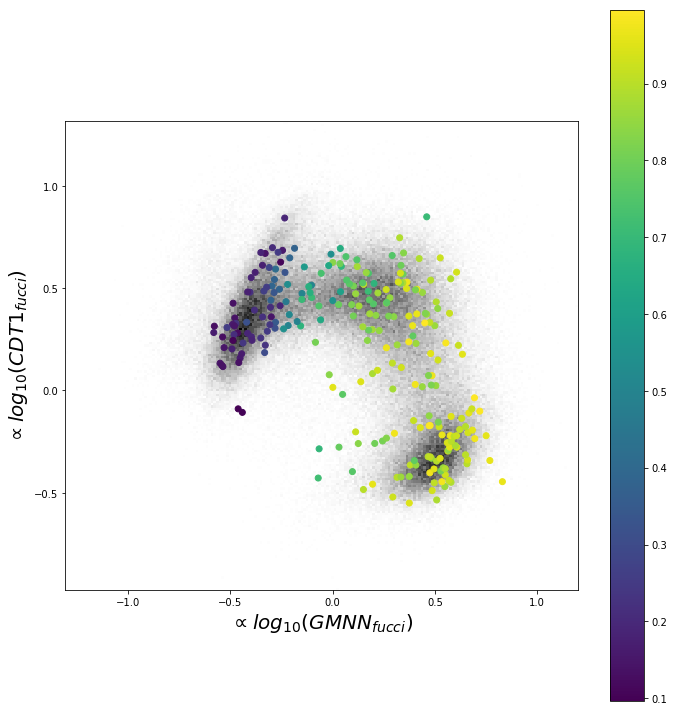

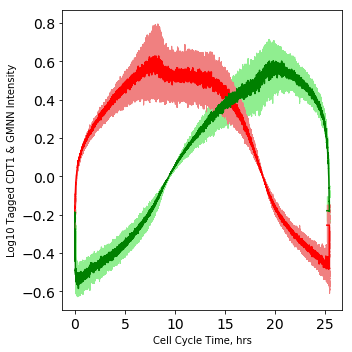

In [8]:
#%% 
# Idea: Calculate the polar coordinates and other stuff
# Exec: Devin's calculations
# Output: fucci plot with polar coordinates

pseudotime_result = FucciPseudotime.pseudotime_protein(fucci_data, 
                           ab_nuc,ab_cyto,ab_cell,mt_cell,area_cell, area_nuc,
                           well_plate,well_plate_imgnb, log_red_fucci_zeroc_rescale,log_green_fucci_zeroc_rescale)
pol_sort_well_plate, pol_sort_norm_rev, pol_sort_well_plate_imgnb, pol_sort_ab_nuc, pol_sort_ab_cyto, pol_sort_ab_cell, pol_sort_mt_cell, pol_sort_area_cell, pol_sort_area_nuc, pol_sort_fred, pol_sort_fgreen = pseudotime_result


Plotting average intensities of proteins and microtubules by batch.


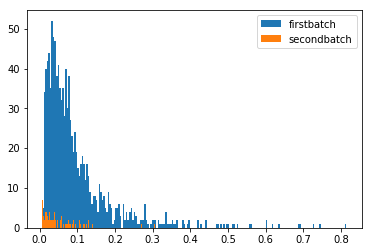

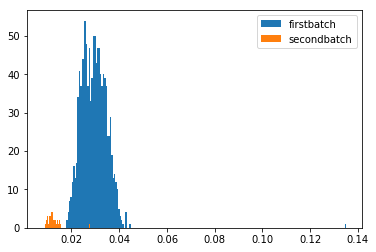

Making general plots for variance, CV, and gini by compartment


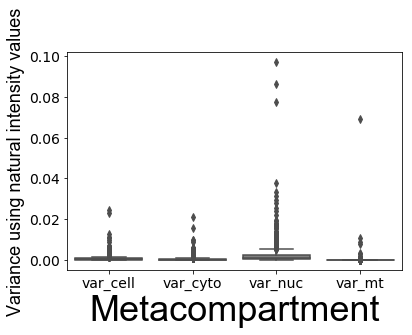

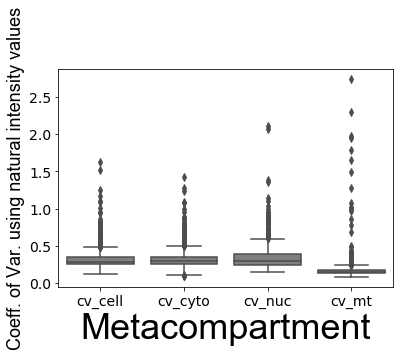

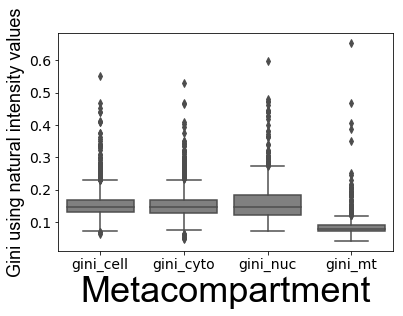

Making general plots for variance, CV, and gini in the compartment the protein localizes to


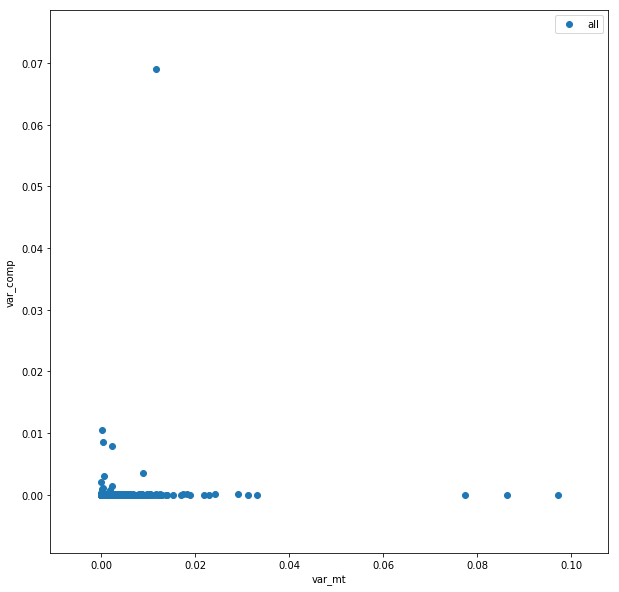

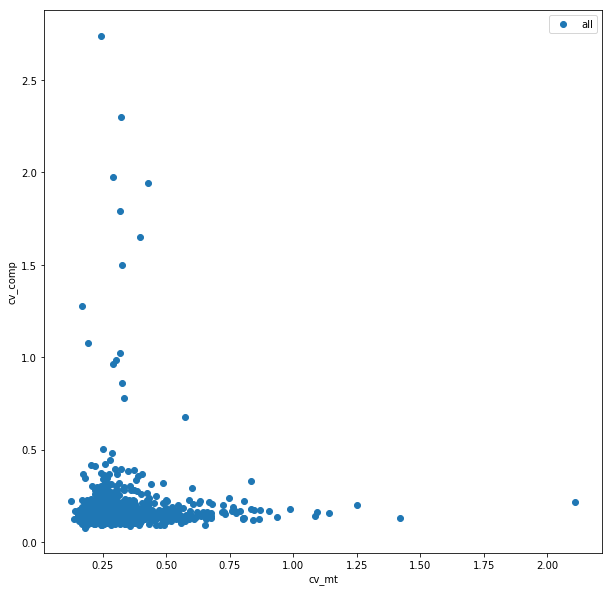

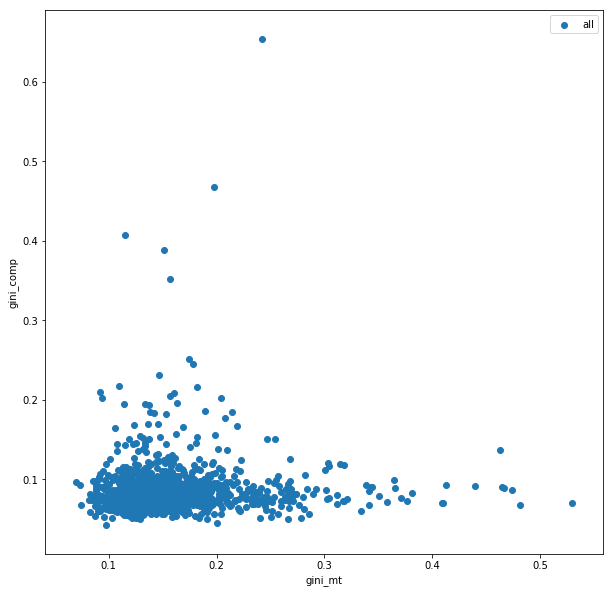

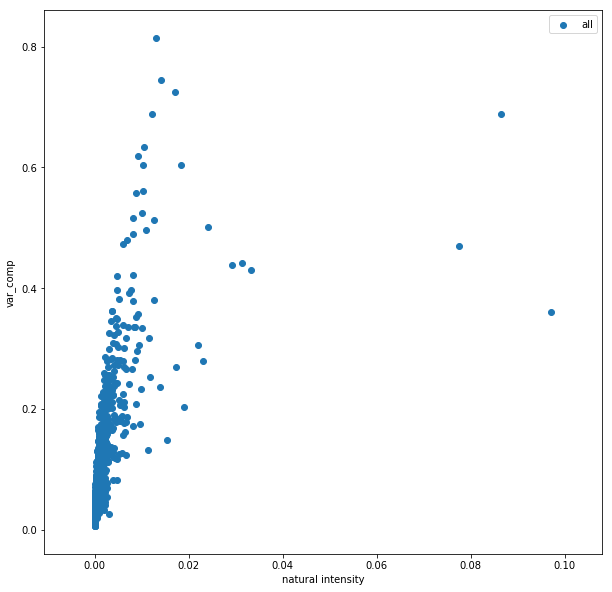

Comparing image to sample variance


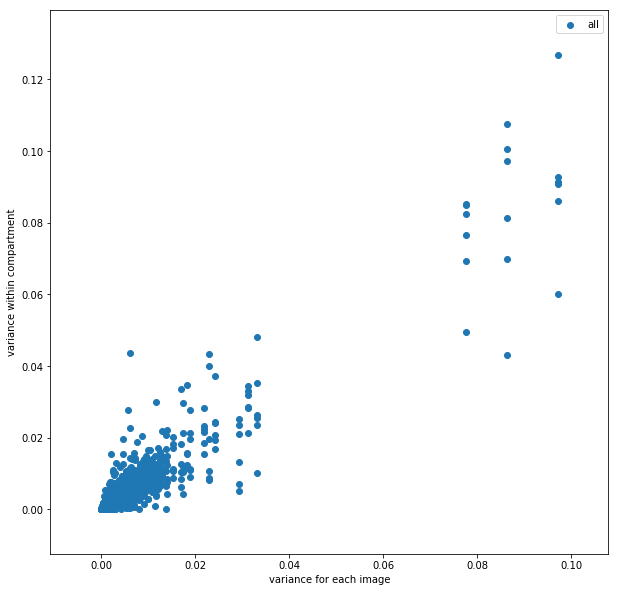

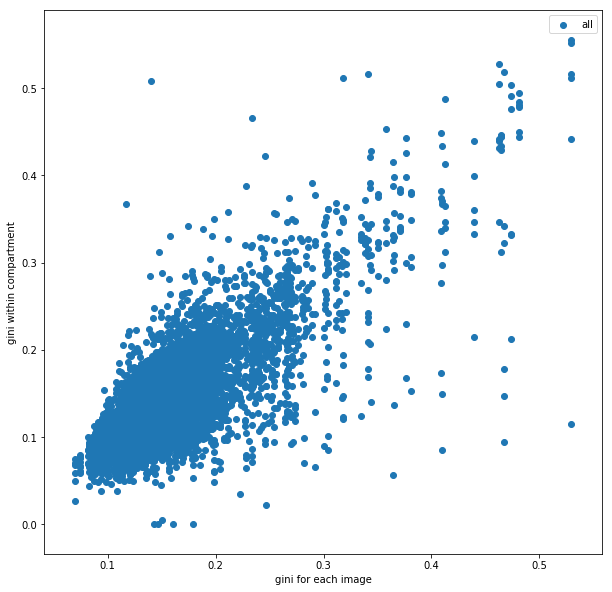

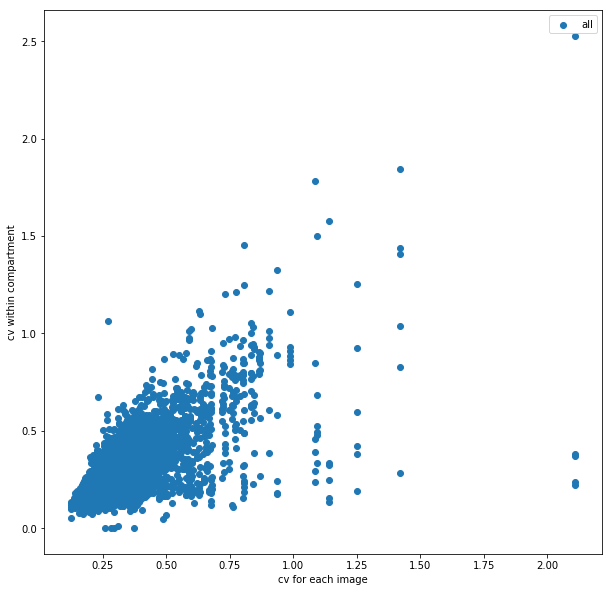

A02_55355986_8: the image with the max variance


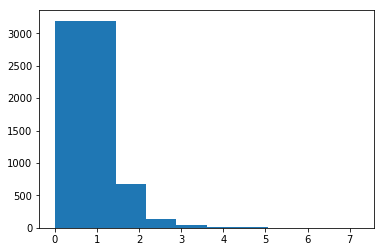

['A03_55185977_15' 'A05_55195978_27' 'B04_55385989_95' 'B05_55205980_101'
 'C05_55365987_174' 'C07_55235979_186' 'C09_55235979_194'
 'C11_55355986_209' 'D06_55365987_250' 'D07_55235979_255'
 'E01_55215982_292' 'E02_55375988_297' 'E05_55375988_314'
 'E11_55205980_353' 'F06_55355986_394' 'F11_55405991_422'
 'H03_55195978_519' 'H06_55355986_536']: the images with greater than 4x the variance of the whole sample


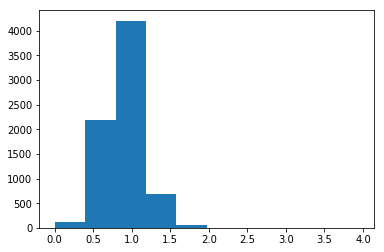

['A02_6736_10' 'A03_55185977_15' 'A05_55195978_27' 'A05_55225983_28'
 'A06_55195978_35' 'A06_55205980_32' 'A08_55235979_43' 'B01_55335984_78'
 'B02_55335984_84' 'B02_55385989_82' 'B03_55355986_85' 'B04_55205980_91'
 'B04_55385989_95' 'B05_55205980_101' 'B08_55215982_118'
 'B09_55355986_125' 'B10_55225983_128' 'B10_55235979_132'
 'B11_55385989_137' 'C01_55235979_147' 'C01_75836284_148'
 'C03_55365987_157' 'C05_55365987_174' 'C06_55185977_177'
 'C06_55355986_175' 'C09_55235979_194' 'C11_55355986_209'
 'C12_55205980_214' 'C12_55365987_215' 'D05_55205980_245'
 'D05_55215982_241' 'D06_55365987_250' 'D08_55195978_264'
 'D09_55195978_270' 'E01_55215982_292' 'E02_55375988_297'
 'E05_55365987_316' 'E09_55365987_337' 'E11_55205980_353'
 'F02_55385989_370' 'F04_75836284_380' 'F05_6734_389' 'F06_55355986_394'
 'F06_75836284_391' 'F09_55215982_414' 'F10_6717_420' 'F11_55395990_425'
 'F11_55405991_422' 'G02_55215982_444' 'G05_55235979_459'
 'G08_55365987_480' 'H01_55215982_507' 'H01_55395990_509'
 '

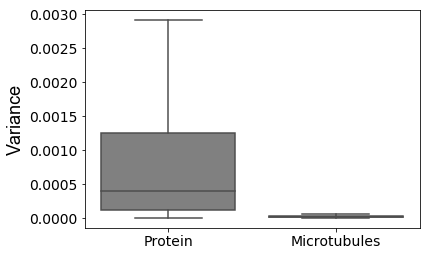

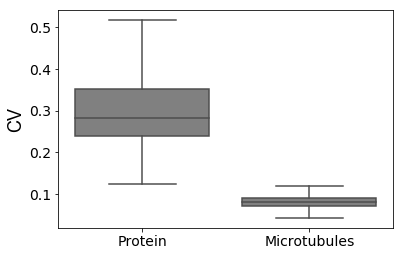

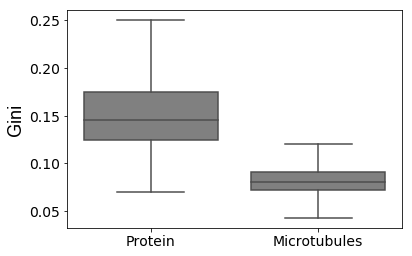

4.933879884898037e-303: p-value for difference between protein and microtubule variances
0.0: p-value for difference between protein and microtubule CVs
0.0: p-value for difference between protein and microtubule Gini indices


In [9]:
#%% Calculate measures of variance of protein abundance in single cells
# Idea: Calculate measures of variance, and show them in plots
# Execution: Now that we already have the data filtered for variability, this is just descriptive.
# Output: scatters of antibody vs microtubule variances by different measures of variaibility

use_log = False # toggle for using log-transformed intensities; we decided to use natural intensities
calculate_variaton_result = ProteinVariability.calculate_variation(use_log, u_well_plates, wp_iscell, wp_isnuc, wp_iscyto, 
                                                pol_sort_well_plate, pol_sort_ab_cell, pol_sort_ab_nuc, pol_sort_ab_cyto, pol_sort_mt_cell, pol_sort_well_plate_imgnb)
mean_mean_comp, var_comp, gini_comp, cv_comp, var_cell, gini_cell, cv_cell, var_mt, gini_mt, cv_mt = calculate_variaton_result

# Compare variances for protein and microtubules, the internal control for each image
general_boxplot((var_comp, var_mt), ("Protein", "Microtubules"), "", "Variance", "", False, f"figures/ProteinMicrotubuleVariances.pdf")
general_boxplot((cv_comp, gini_mt), ("Protein", "Microtubules"), "", "CV", "", False, f"figures/ProteinMicrotubuleCVs.pdf")
general_boxplot((gini_comp, gini_mt), ("Protein", "Microtubules"), "", "Gini", "", False, f"figures/ProteinMicrotubuleGinis.pdf")
print(f"{scipy.stats.kruskal(var_comp, var_mt)[1]}: p-value for difference between protein and microtubule variances")
print(f"{scipy.stats.kruskal(cv_comp, gini_mt)[1]}: p-value for difference between protein and microtubule CVs")
print(f"{scipy.stats.kruskal(gini_comp, gini_mt)[1]}: p-value for difference between protein and microtubule Gini indices")


1013: number of proteins displaying unimodal distributions (0.8084596967278531%)
240: number of proteins displaying bimodal distributions (0.19154030327214686%)


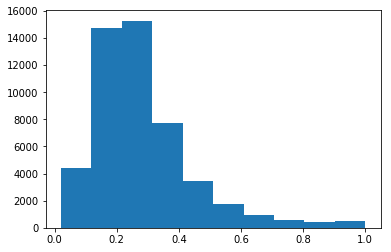

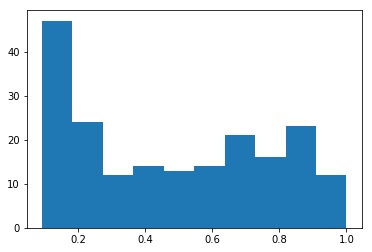

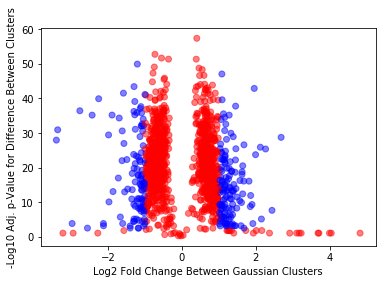

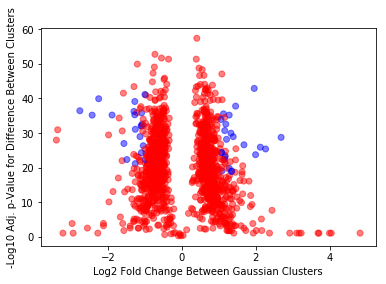

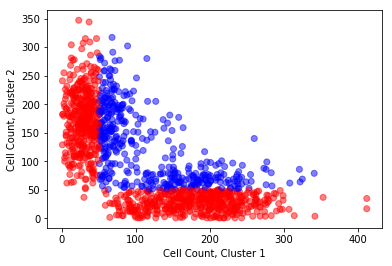

In [10]:
#%% Gaussian clustering to identify biomodal intensity distributions
bimodal_results = ProteinBimodality.identify_bimodal_intensity_distributions(u_well_plates, wp_ensg,
             pol_sort_well_plate, pol_sort_norm_rev, pol_sort_ab_cell, pol_sort_ab_nuc, pol_sort_ab_cyto, pol_sort_mt_cell,
             wp_iscell, wp_isnuc, wp_iscyto)
wp_isbimodal_fcpadj_pass, wp_bimodal_cluster_idxs, wp_isbimodal_generally, wp_bimodal_fcmaxmin = bimodal_results


well 0 of 1253
well 100 of 1253
well 200 of 1253
well 300 of 1253
well 400 of 1253
well 500 of 1253
well 600 of 1253
well 700 of 1253
well 800 of 1253
well 900 of 1253
well 1000 of 1253
well 1100 of 1253
well 1200 of 1253
Requiring 8.0% additional percent variance explained than random.
1253: number of genes with randomized percvars that form normal distributions
329: # proteins showing CCD variation unimodally, comp, percvar rng median diff
0.26256983240223464: fraction of variable proteins showing CCD variation, comp, percvar rng median diff
331: # proteins showing CCD variation, comp, gaussian analysis
0.2641660015961692: fraction of variable proteins showing CCD variation, comp, gaussian analysis
225: # proteins showing CCD variation, CCD and gaussian
106: # proteins showing CCD variation, not CCD and gaussian
104: # proteins showing CCD variation, CCD and not gaussian
43: samples with bimodal antibody intensities
12: bimodal samples with one CCD cluster (2: also CCD unimodally)
2:

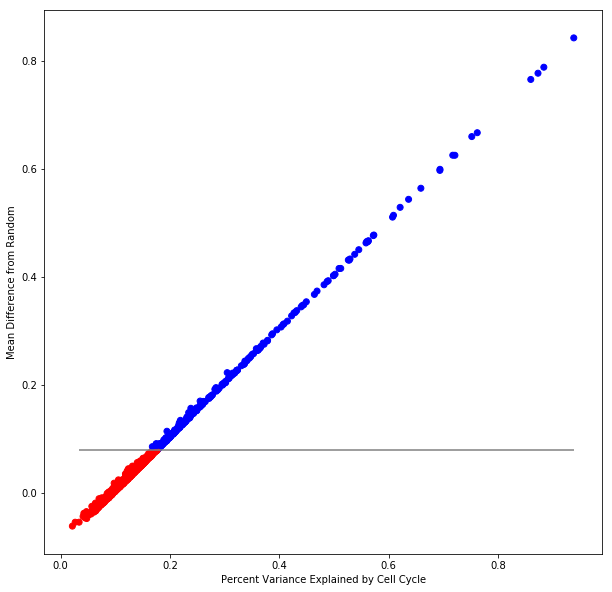

C:\Users\antho\Documents\Projects\CellCycle\FucciRNA\SingleCellProteogenomics\ProteinCellCycleDependence.py:259: RuntimeWarning: divide by zero encountered in log10
  plt.vlines(MIN_MEAN_PERCVAR_DIFF_FROM_RANDOM, np.min(-np.log10(pervar_adj_withbimodal_nextafter)), np.max(-np.log10(wp_comp_eq_percvar_adj_withbimodal)), color="gray")


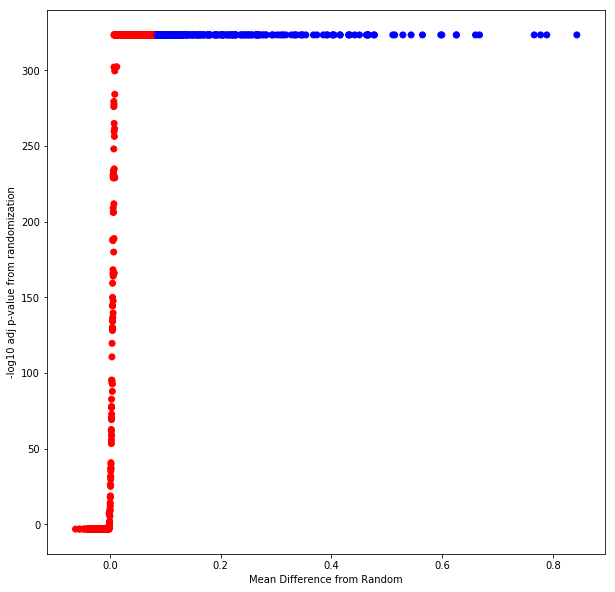

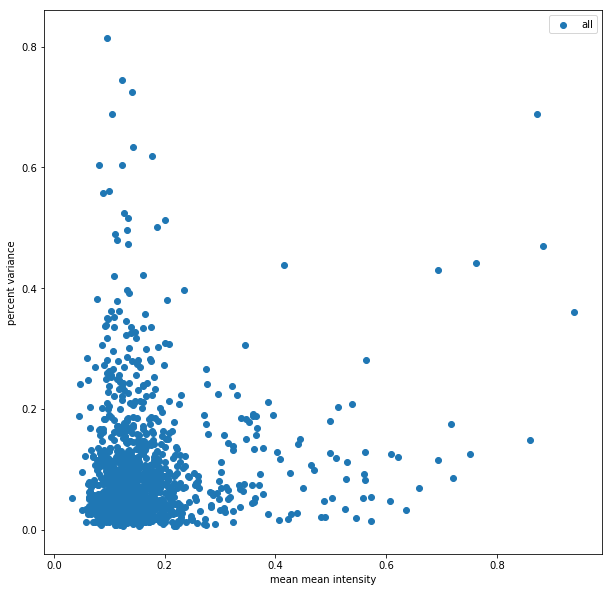

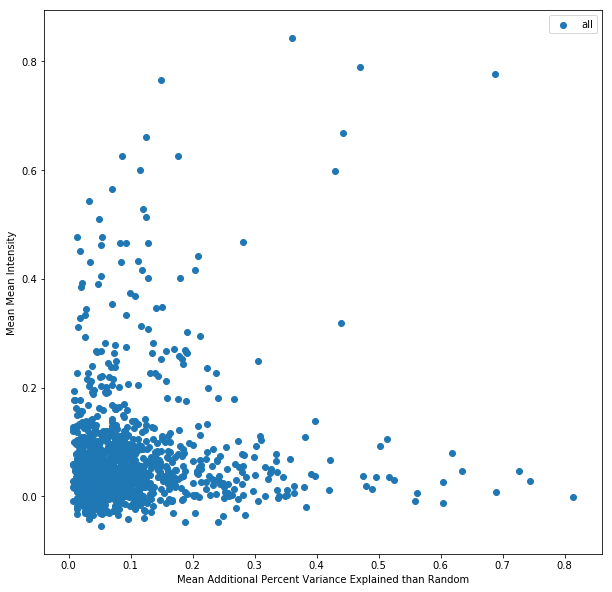

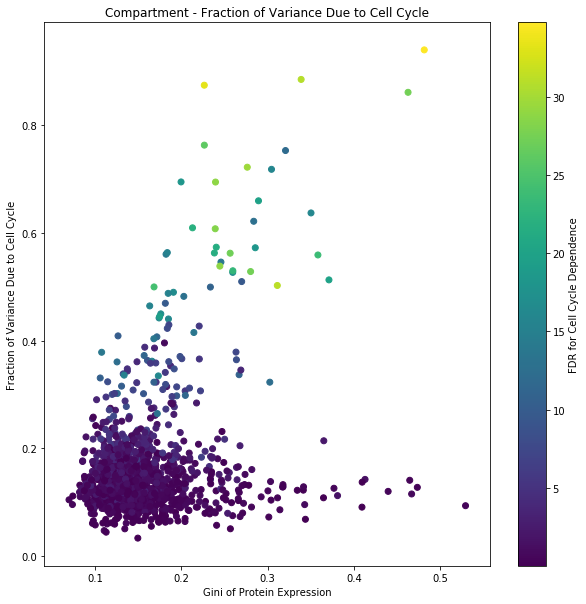

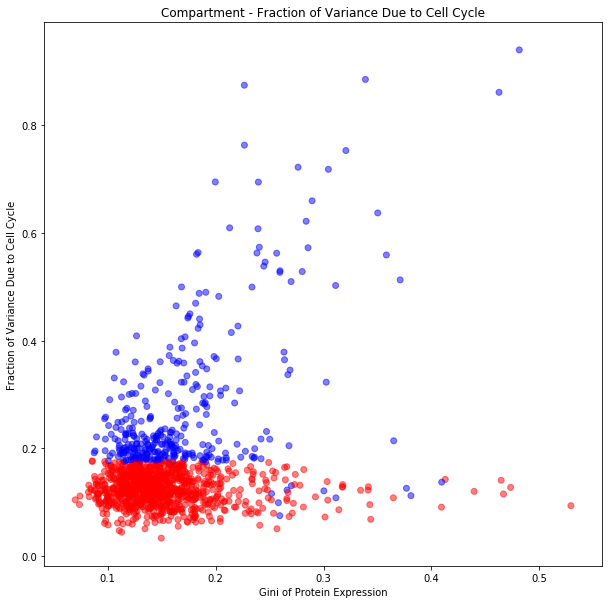

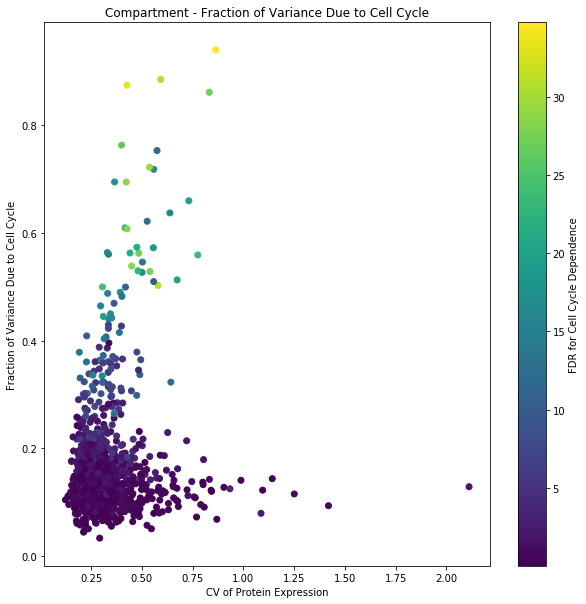

C:\Users\antho\Documents\Projects\CellCycle\FucciRNA\SingleCellProteogenomics\ProteinCellCycleDependence.py:351: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(perc_var_comp, -np.log10(wp_comp_eq_percvar_adj))


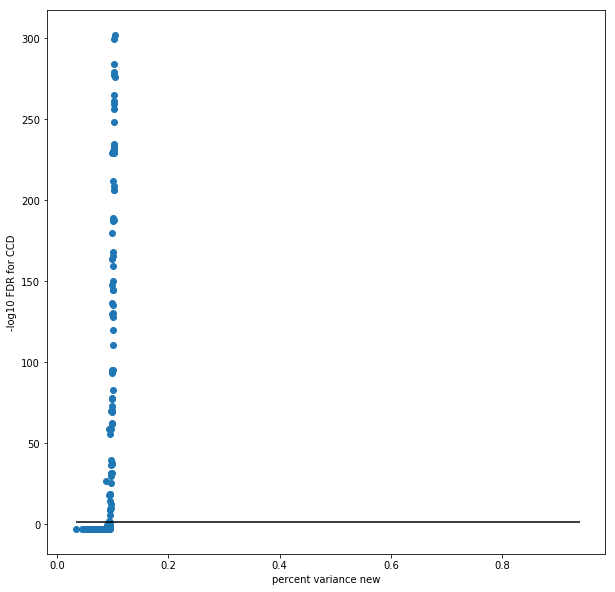

1253: # total proteins showing variation
339: CCD variable proteins (before addressing redundancy and mitotic structures)
914: non-CCD variable proteins
316: number of CCD proteins (no replicate, unimodal and bimodal)
869: number of non-CCD proteins (no replicate, unimodal and bimodal)
12: bimodal samples with one CCD cluster (2: also CCD unimodally), no replicate
2: bimodal samples with two CCD clusters (2: also CCD unimodally), no replicate
5: number of replicated stainings shown to be CCD in both replicates, unimodal and bimodal
13: number of replicated stainings shown to be CCD in just one replicate, unimodal and bimodal
16: number of replicated stainings shown to be non-CCD in both replicate, unimodal and bimodal
0: number of replicated stainings shown to be CCD in both replicates, bimodal in one cluster (0 also unimodally)
0: number of replicated stainings shown to be CCD in just one replicate, bimodal in one cluster (0 also unimodally)
34: number of replicated stainings shown to

In [11]:
#%% Determine cell cycle dependence for each protein
use_log_ccd = False
do_remove_outliers = True
alphaa = 0.05

# Determine cell cycle dependence for proteins
ccd_results = ProteinCellCycleDependence.cell_cycle_dependence_protein(
        u_well_plates, wp_ensg, use_log_ccd, do_remove_outliers,
        pol_sort_well_plate, pol_sort_norm_rev, pol_sort_ab_cell, pol_sort_ab_nuc, pol_sort_ab_cyto, pol_sort_mt_cell,
        pol_sort_area_cell, pol_sort_area_nuc,
        wp_iscell, wp_isnuc, wp_iscyto,
        wp_isbimodal_fcpadj_pass, wp_bimodal_cluster_idxs, wp_comp_kruskal_gaussccd_adj)
wp_comp_ccd_difffromrng, wp_comp_ccd_clust1, wp_comp_ccd_clust2, wp_ccd_unibimodal, wp_comp_ccd_gauss, perc_var_comp, mean_diff_from_rng, wp_comp_eq_percvar_adj, mean_diff_from_rng_clust1, wp_comp_eq_percvar_adj_clust1, mean_diff_from_rng_clust2, wp_comp_eq_percvar_adj_clust2, folder = ccd_results

# Move the temporal average plots to more informative places
ProteinCellCycleDependence.copy_mvavg_plots_protein(folder, wp_ensg, wp_comp_ccd_difffromrng, wp_isbimodal_fcpadj_pass, wp_comp_ccd_clust1, wp_comp_ccd_clust2, wp_ccd_unibimodal, wp_comp_ccd_gauss)
ProteinCellCycleDependence.global_plots_protein(alphaa, u_well_plates, wp_ccd_unibimodal, perc_var_comp, mean_mean_comp, gini_comp, cv_comp, mean_diff_from_rng, wp_comp_eq_percvar_adj, wp_comp_kruskal_gaussccd_adj)
ProteinCellCycleDependence.analyze_ccd_variation_protein(
    folder, u_well_plates, wp_ensg, wp_ab, wp_iscell, wp_isnuc, wp_iscyto,
    wp_comp_ccd_difffromrng, wp_comp_ccd_clust1, wp_comp_ccd_clust2, 
    var_comp, gini_comp, 
    mean_diff_from_rng, wp_comp_kruskal_gaussccd_adj, wp_comp_eq_percvar_adj, 
    mean_diff_from_rng_clust1, wp_comp_eq_percvar_adj_clust1, mean_diff_from_rng_clust2, wp_comp_eq_percvar_adj_clust2,
    wp_isbimodal_fcpadj_pass, wp_isbimodal_generally, wp_ccd_unibimodal, wp_bimodal_fcmaxmin, wp_comp_ccd_gauss)


## RNA FUCCI Pseudotime
Analysis of transcript abundance in individual cells over cell division time.
-  Cell division time is measured with FUCCI markers and modeled in log-log space using polar coordinates.
-  RNA abundance was measured with single-cell RNA sequencing.
-  FUCCI marker intensities are measured for each individual cell with fluorescence assisted cell sorting (FACS)

In [12]:
bioccd = np.genfromtxt("input/processed/manual/biologically_defined_ccd.txt", dtype='str') # from mitotic structures
wp_ensg = np.load("output/pickles/wp_ensg.npy", allow_pickle=True)
ccd_comp = np.load("output/pickles/ccd_comp.npy", allow_pickle=True)
nonccd_comp = np.load("output/pickles/nonccd_comp.npy", allow_pickle=True)

filtering for biotype: protein_coding


Trying to set attribute `.obs` of view, making a copy.


data shape: (1152, 19997)


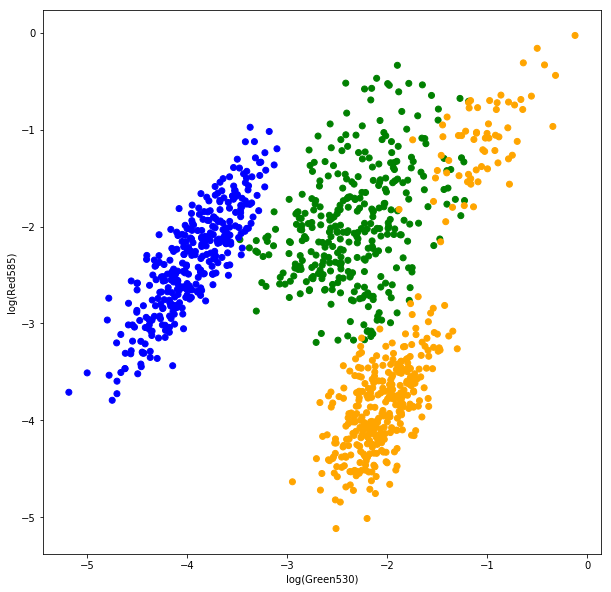

[-2.71756289 -2.61254505]
[-2.71756293 -2.61254505]
[-2.71756289 -2.61254509]
[-2.73525994 -2.75869447]
[-2.73525998 -2.75869447]
[-2.73525994 -2.75869451]
[-2.76274555 -2.81256707]
[-2.76274559 -2.81256707]
[-2.76274555 -2.81256712]
[-2.77752292 -2.82916345]
[-2.77752297 -2.82916345]
[-2.77752292 -2.82916349]
[-2.78348755 -2.83461652]
[-2.78348759 -2.83461652]
[-2.78348755 -2.83461656]
[-2.7856932 -2.8364897]
[-2.78569324 -2.8364897 ]
[-2.7856932  -2.83648975]
[-2.78648524 -2.83714519]
[-2.78648528 -2.83714519]
[-2.78648524 -2.83714523]
[-2.78676679 -2.83737613]
[-2.78676683 -2.83737613]
[-2.78676679 -2.83737617]
[-2.78686653 -2.83745768]
[-2.78686657 -2.83745768]
[-2.78686653 -2.83745772]
[-2.78690181 -2.8374865 ]
[-2.78690186 -2.8374865 ]
[-2.78690181 -2.83748655]


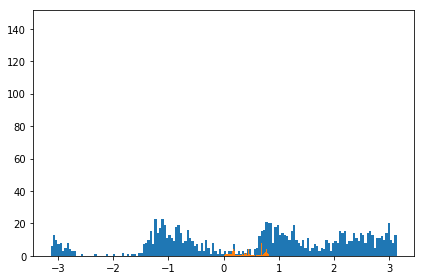

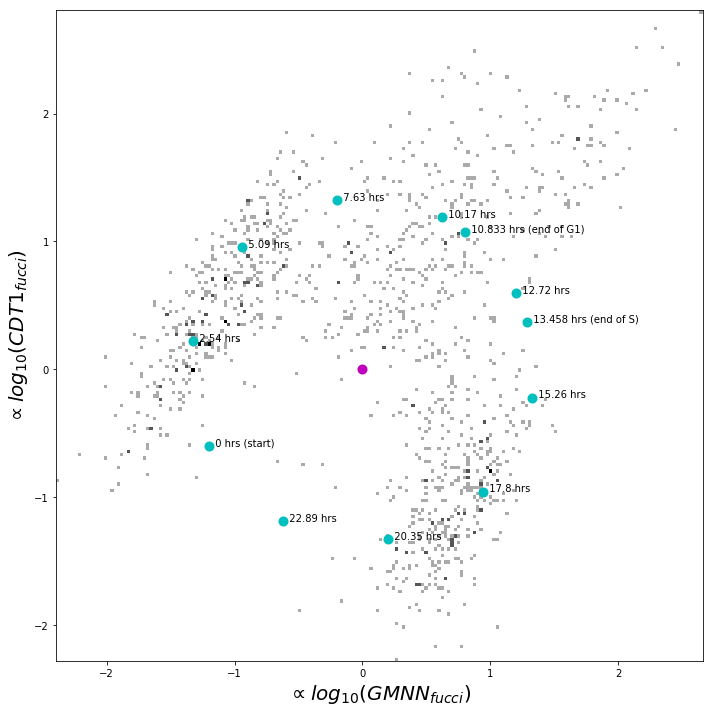

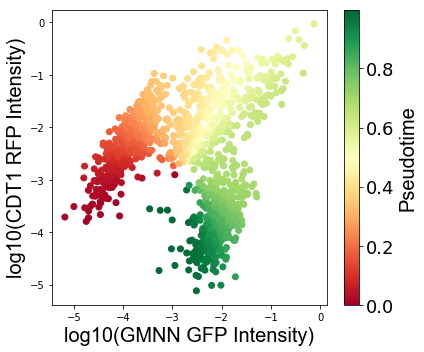

In [19]:
#%% Convert FACS intensities for FUCCI markers to pseudotime using the same polar coordinate methods as for protein
# Idea: Use the polar coordinate pseudotime calculations to calculate the pseudotime for each cell
# Execution: Adapt Devin's code for the cells sorted for RNA-Seq
# Output: Make log-log fucci intensity plots for the cells analyzed by RNA-Seq; Plot of all fucci pseudotimes; table of pseudotimes for each cell
adata, phases_filt = RNADataPreparation.read_counts_and_phases("Counts", False, "protein_coding") # no qc, yet
FucciPseudotime.pseudotime_rna(adata, phases_filt)

filtering for biotype: protein_coding


Trying to set attribute `.obs` of view, making a copy.


data shape: (1152, 19997)


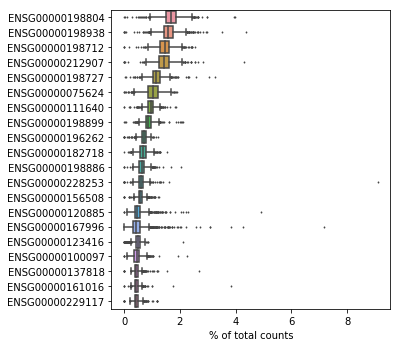

data shape after filtering: (1138, 13450)


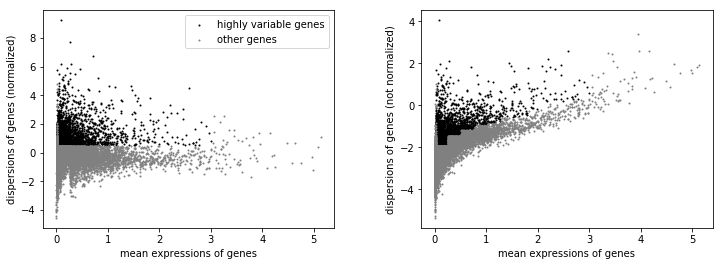

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'phase' as categorical
... storing 'louvain' as categorical
... storing 'name' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical


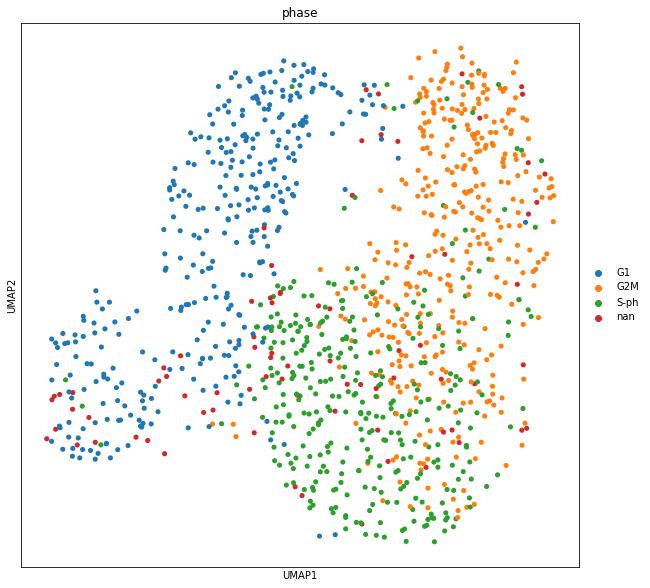

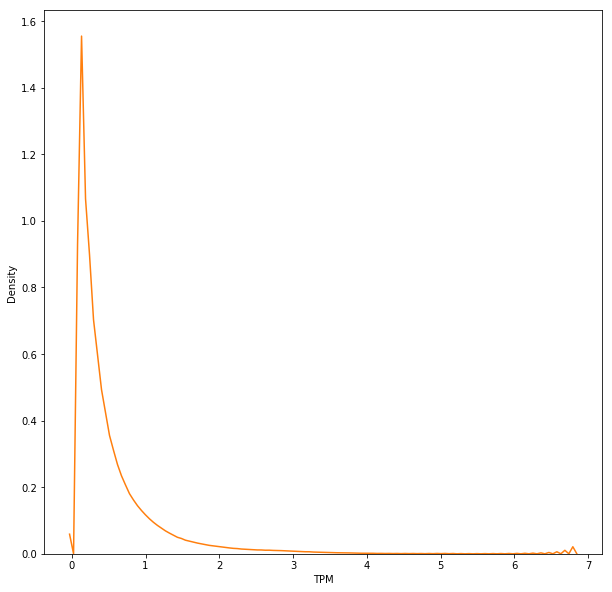

filtering for biotype: protein_coding


Trying to set attribute `.obs` of view, making a copy.


data shape: (1152, 19997)
data shape after filtering: (1138, 13450)
         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'phase' as categorical
... storing 'louvain' as categorical
... storing 'name' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical


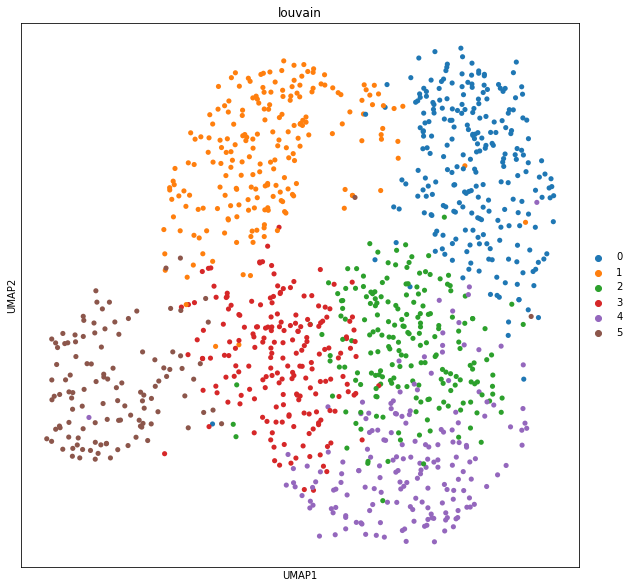

filtering for biotype: protein_coding


Trying to set attribute `.obs` of view, making a copy.


data shape: (1152, 19997)
data shape after filtering: (1021, 13450)
         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'phase' as categorical
... storing 'louvain' as categorical
... storing 'name' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical


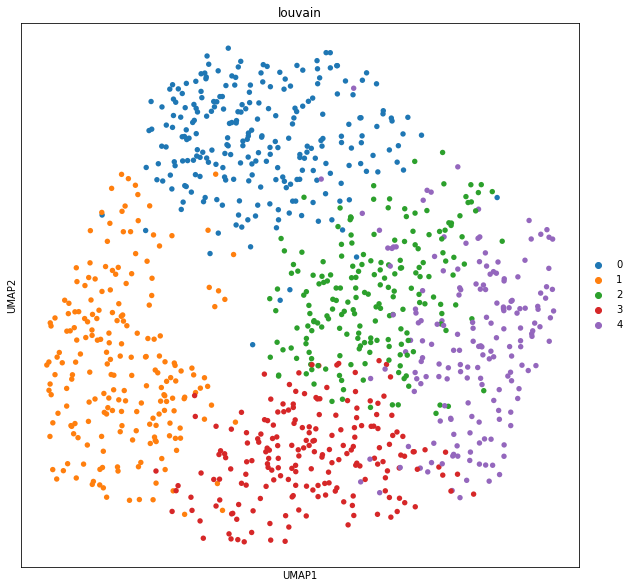

In [20]:
#%% Single cell RNA-Seq data preparation and general analysis
RNADataPreparation.general_plots()
RNADataPreparation.analyze_noncycling_cells()


In [21]:
#%% Idea: Similar to mock-bulk analysis for proteins, we can evaluate each gene bundled by phase across cells
# Execution: Make boxplots of RNA expression by phase
# Output: boxplots for each gene
valuetype, use_spikeins, biotype_to_use = "Tpms", False, "protein_coding"
adata, phases = RNADataPreparation.read_counts_and_phases(valuetype, use_spikeins, biotype_to_use)
adata, phasesfilt = RNADataPreparation.qc_filtering(adata, do_log_normalize=True, do_remove_blob=True)
g1, s, g2 = adata.obs["phase"] == "G1", adata.obs["phase"] == "S-ph", adata.obs["phase"] == "G2M"
do_make_boxplots = False
if do_make_boxplots:
    for iii, ensg in enumerate(adata.var_names):
        maxtpm = np.max(np.concatenate((adata.X[g1,iii], adata.X[s,iii], adata.X[g2,iii])))
        RNACellCycleDependence.boxplot_result(adata.X[g1,iii] / maxtpm, adata.X[s,iii] / maxtpm, adata.X[g2,iii] / maxtpm, "figures/RNABoxplotByPhase", ensg)


filtering for biotype: protein_coding


Trying to set attribute `.obs` of view, making a copy.


data shape: (1152, 19997)
data shape after filtering: (1021, 13450)


         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'phase' as categorical
... storing 'louvain' as categorical
... storing 'name' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical


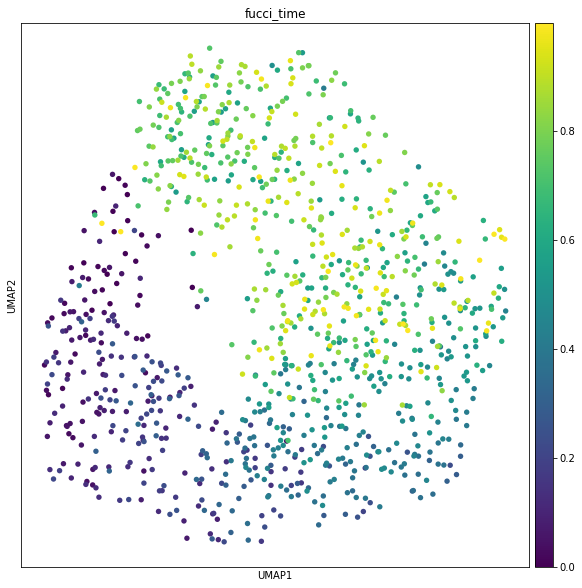

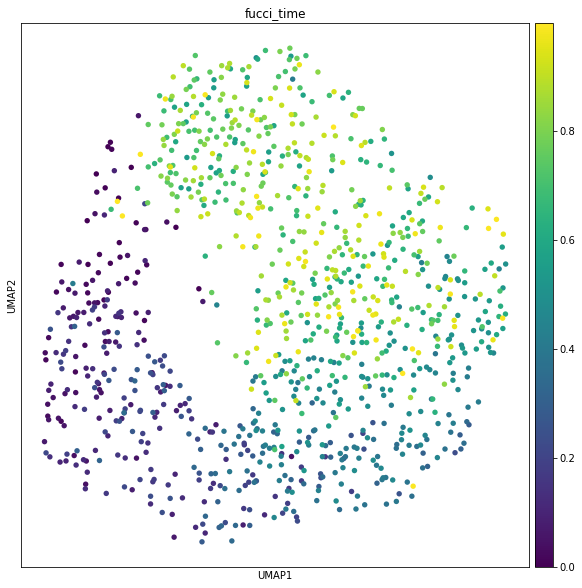

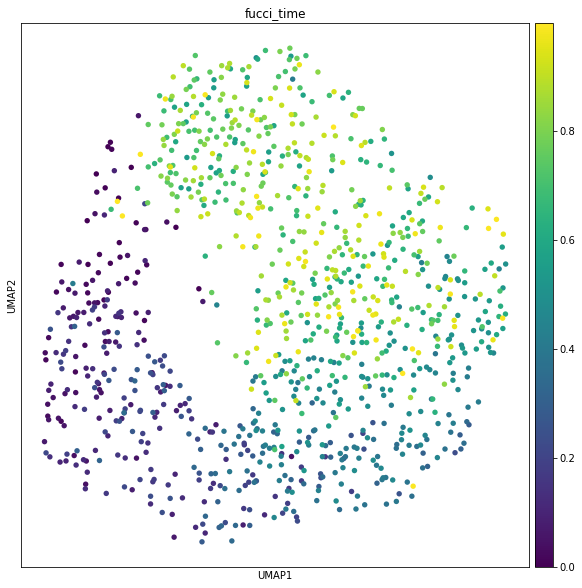

In [22]:
#%% Idea: Display general RNA expression patterns in single cells using UMAP dimensionality reduction, and display with FUCCI pseudotime overlayed
FucciPseudotime.pseudotime_umap(adata) # Generate a UMAP with the pseudotime overlayed

# We can also show that the cycle pattern remains when the curated CCD genes or CCD proteins are removed,
# demonstrating that there's still valuable information about cell cycling beyond what was called CCD
RNADataPreparation.demonstrate_umap_cycle_without_ccd(adata)

# Read in the currated CCD genes / CCD proteins from the present work / Non-CCD genes from the present work; filter for genes that weren't filtered in QC of RNA-Seq
bioccd = np.genfromtxt("input/processed/manual/biologically_defined_ccd.txt", dtype='str') # from mitotic structures in the protein work
ccd_regev_filtered, ccd_filtered, nonccd_filtered = utils.ccd_gene_lists(adata)
adata_ccdprotein, adata_nonccdprotein, adata_regevccdgenes = RNADataPreparation.is_ccd(adata, wp_ensg, ccd_comp, nonccd_comp, bioccd, ccd_regev_filtered)

# Generate plots with expression of genes overlayed
do_make_gene_expression_plots = False
expression_data = adata.X
normalized_exp_data = (expression_data.T / np.max(expression_data, axis=0)[:,None]).T
if do_make_gene_expression_plots:
    # UMAPs with RNA expression overlayed
    RNACellCycleDependence.plot_expression_umap(adata, ccd_regev_filtered, "figures/RegevGeneExpressionUmap") # curated CCD genes from a different scRNA-Seq analysis
    RNACellCycleDependence.plot_expression_umap(adata, ccd_filtered, "figures/CcdGeneExpressionUmap") # CCD proteins from the present immunofluorescense work
    RNACellCycleDependence.plot_expression_umap(adata, nonccd_filtered, "figures/NonCcdGeneExpressionUmap") # non-CCD proteins from the present immunofluorescense work

    # Log-log FUCCI plot with RNA expression overlayed
    RNACellCycleDependence.plot_expression_facs(ccd_regev_filtered, normalized_exp_data, phasesfilt, adata.var_names, "figures/RegevGeneFucci")
    RNACellCycleDependence.plot_expression_facs(ccd_filtered, normalized_exp_data, phasesfilt, adata.var_names, "figures/CcdGeneFucci")
    RNACellCycleDependence.plot_expression_facs(nonccd_filtered, normalized_exp_data, phasesfilt, adata.var_names, "figures/NonCcdGeneFucci")

# Cluster the expression into phases and analyze it that way
bulk_phase_tests = RNACellCycleDependence.analyze_ccd_variation_by_phase_rna(adata, normalized_exp_data, biotype_to_use)
if do_make_gene_expression_plots:
     # Remove?
    RNACellCycleDependence.plot_expression_boxplots(adata, ccd_regev_filtered, bulk_phase_tests, "figures/RegevGeneBoxplots")
    RNACellCycleDependence.plot_expression_boxplots(adata, ccd_filtered, bulk_phase_tests, "figures/CcdGeneBoxplots")
    RNACellCycleDependence.plot_expression_boxplots(adata, nonccd_filtered, bulk_phase_tests, "figures/NonCcdGeneBoxplots")

C:\Users\antho\Documents\Projects\CellCycle\FucciRNA\SingleCellProteogenomics\RNACellCycleDependence.py:201: RuntimeWarning: divide by zero encountered in log10
  "-log10 CCD FDR":-np.log10(eq_percvar_adj)})


--- RNA pseudotime

We identified 401 genes of 13450 protein-coding genes analyzed (2.9814126394052045%) to have variance in expression levels correlated to cell cycle progression

We can attribute only 14.96881496881497% of proteomic cell cycle regulation to transcriptomic cycling with single-cell RNA sequencing

This includes 86.17021276595744% of known CCD transcripts. Of these, 72 were also cell cycle dependent proteins (14.96881496881497%). Of the 481 CCD proteins, 409 did not have CCD transcripts, including DUSP18 (Figure 2E). There were 28 CCD transcripts that were Non-CCD as proteins.




401: number of transcripts that pass CCD by mean percvar diff from random > 0.08
49: number of CCD transcripts that are also CCD proteins
0.8617021276595744: percent of Regev CCD transcripts that are called CCD with this analysis


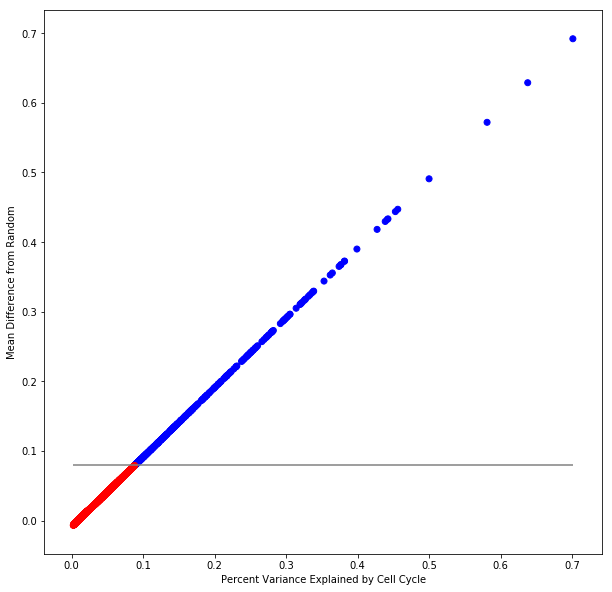

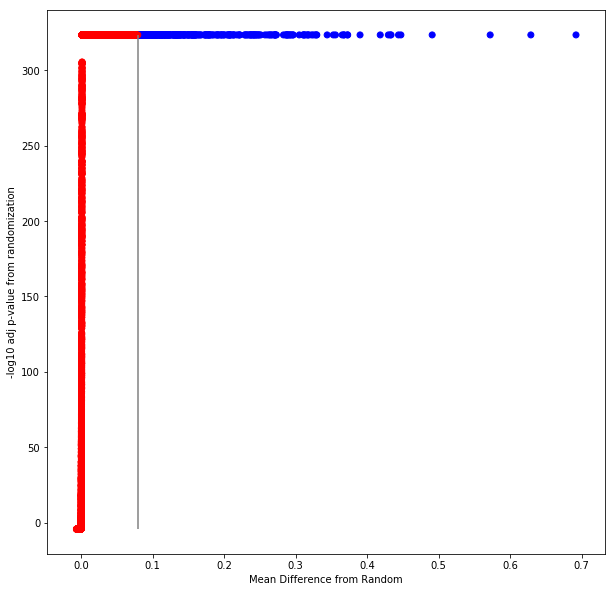

well 0 of 13450
well 500 of 13450
well 1000 of 13450
well 1500 of 13450
well 2000 of 13450
well 2500 of 13450
well 3000 of 13450
well 3500 of 13450
well 4000 of 13450
well 4500 of 13450
well 5000 of 13450
well 5500 of 13450
well 6000 of 13450
well 6500 of 13450
well 7000 of 13450
well 7500 of 13450
well 8000 of 13450
well 8500 of 13450
well 9000 of 13450
well 9500 of 13450
well 10000 of 13450
well 10500 of 13450
well 11000 of 13450
well 11500 of 13450
well 12000 of 13450
well 12500 of 13450
well 13000 of 13450


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


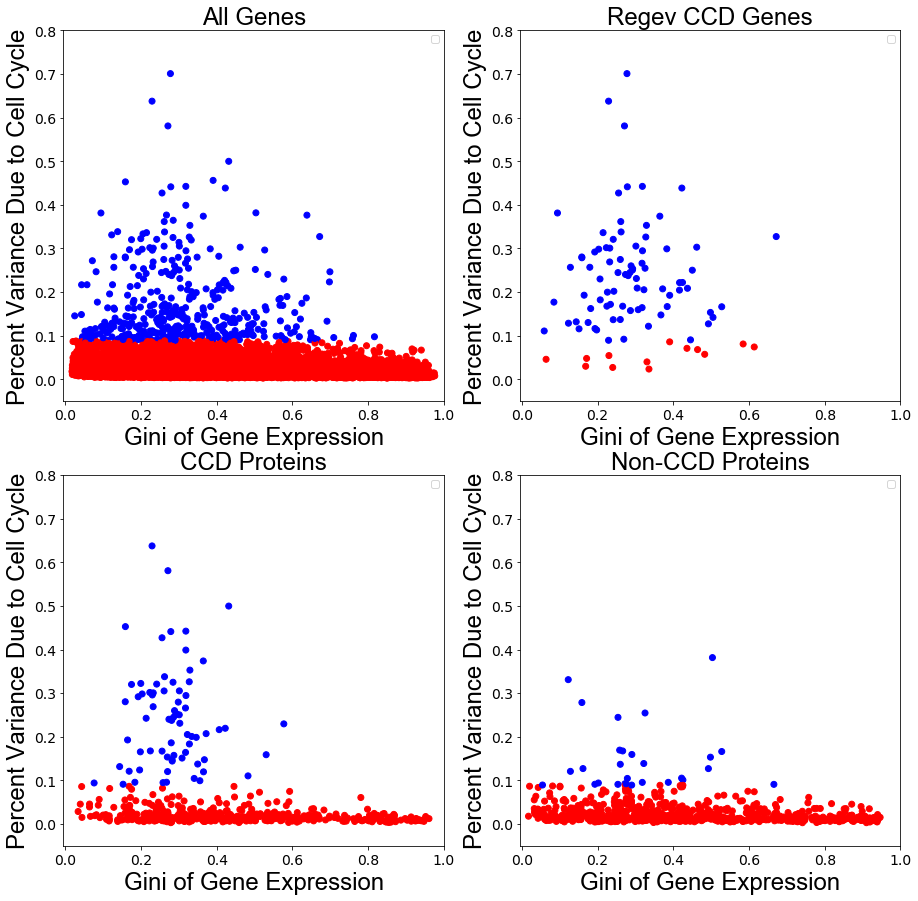

No handles with labels found to put in legend.


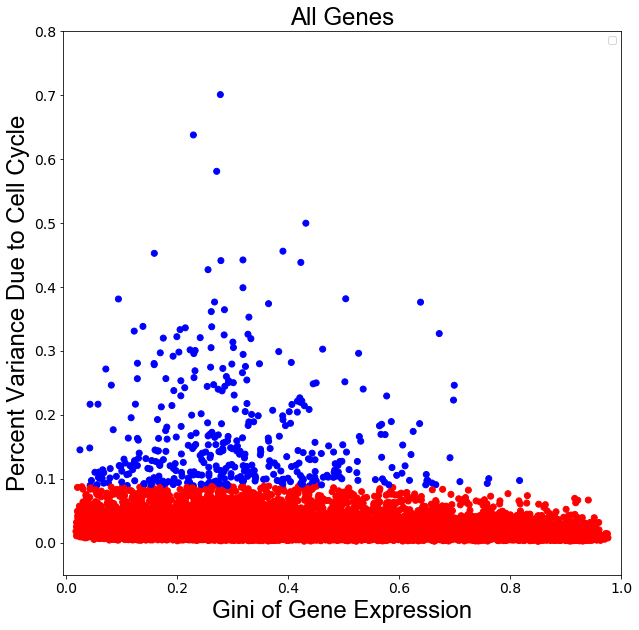

In [23]:
#%% Moving average calculations and randomization analysis for RNA
rna_ccd_analysis_results = RNACellCycleDependence.analyze_ccd_variation_by_mvavg_rna(adata, wp_ensg, ccd_comp, bioccd, adata_nonccdprotein, adata_regevccdgenes, biotype_to_use)
percent_ccd_variance, total_gini, mean_diff_from_rng, pass_meandiff, eq_percvar_adj, fucci_time_inds, norm_exp_sort, moving_averages, mvavg_xvals, perms = rna_ccd_analysis_results

RNACellCycleDependence.figures_ccd_analysis_rna(adata, percent_ccd_variance, mean_diff_from_rng, pass_meandiff, eq_percvar_adj, wp_ensg, ccd_comp, ccd_regev_filtered)
RNACellCycleDependence.mvavg_plots_pergene(adata, fucci_time_inds, norm_exp_sort, moving_averages, mvavg_xvals)
RNACellCycleDependence.plot_overall_and_ccd_variances(adata, biotype_to_use, total_gini, percent_ccd_variance, pass_meandiff, adata_ccdprotein, adata_nonccdprotein, adata_regevccdgenes)



Trying to set attribute `.obs` of view, making a copy.


data shape: (1152, 92)
data shape after filtering: (1146, 25)
Percent variance of spike-in:
mean +/- stdev of spike-in variance explained by cell cycle: 0.05809119130045735 +/- 0.04985247926405128
median of spike-in variance explained by cell cycle: 0.029103098797890345
permutation 0
permutation 1000
permutation 2000
permutation 3000
permutation 4000
permutation 5000
permutation 6000
permutation 7000
permutation 8000
permutation 9000
Percent additional variance CCD than random of spike-in
mean +/- stdev of spike-in mean additional percent variance from random: 0.0491312724485606 +/- 0.049859604407059326
median of spike-in addtional variance explained by cell cycle than random: 0.020102261481739218


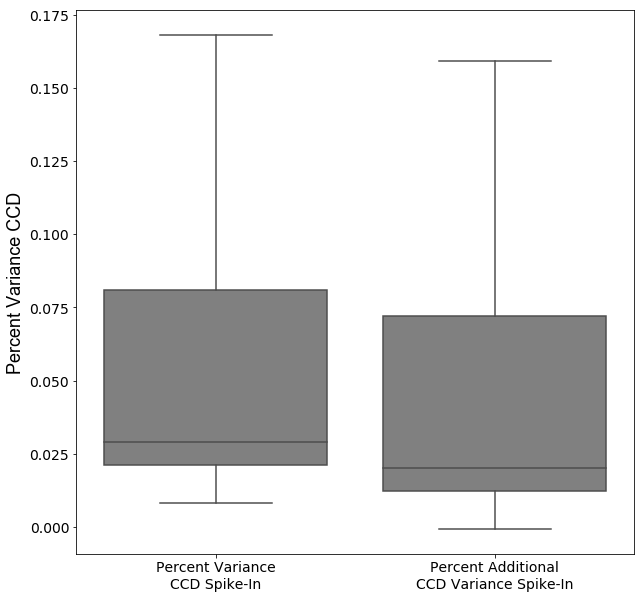

In [24]:
#%% Moving average calculations and randomization analysis for the spike-in internal controls
adata_spikeins, phases_spikeins = RNADataPreparation.read_counts_and_phases(plate, valuetype, use_spike_ins=True, biotype_to_use="")
sc.pp.filter_genes(adata_spikeins, min_cells=100)
print(f"data shape after filtering: {adata_spikeins.X.shape}")

RNACellCycleDependence.ccd_analysis_of_spikeins(adata_spikeins, perms)

## Temporal delay of peak protein and RNA expression
Comparison of the times of peak expression for protein and RNA for each gene
-  The peak expression for each protein and transcript were determined using the FUCCI pseudotime analysis
-  This is the first demonstration of the temporal delay between protein and RNA on the single cell level

In [25]:
#%% Read in the protein data
import_dict = Loaders.load_temporal_delay()
u_well_plates, wp_ensg = import_dict["u_well_plates"], import_dict["wp_ensg"]
wp_iscell, wp_isnuc, wp_iscyto = import_dict["wp_iscell"], import_dict["wp_isnuc"], import_dict["wp_iscyto"]
ccd_comp, ccdtranscript = import_dict["ccd_comp"], import_dict["ccdtranscript"] 
pol_sort_well_plate, pol_sort_norm_rev = import_dict["pol_sort_well_plate"], import_dict["pol_sort_norm_rev"]
pol_sort_ab_nuc, pol_sort_ab_cyto, pol_sort_ab_cell, pol_sort_mt_cell = import_dict["pol_sort_ab_nuc"], import_dict["pol_sort_ab_cyto"], import_dict["pol_sort_ab_cell"], import_dict["pol_sort_mt_cell"]
var_comp_prot, gini_comp_prot, cv_comp_prot = import_dict["var_comp"], import_dict["gini_comp"], import_dict["cv_comp"]
var_cell_prot, gini_cell_prot, cv_cell_prot = import_dict["var_cell"], import_dict["gini_cell"], import_dict["cv_cell"]

C:\Users\antho\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


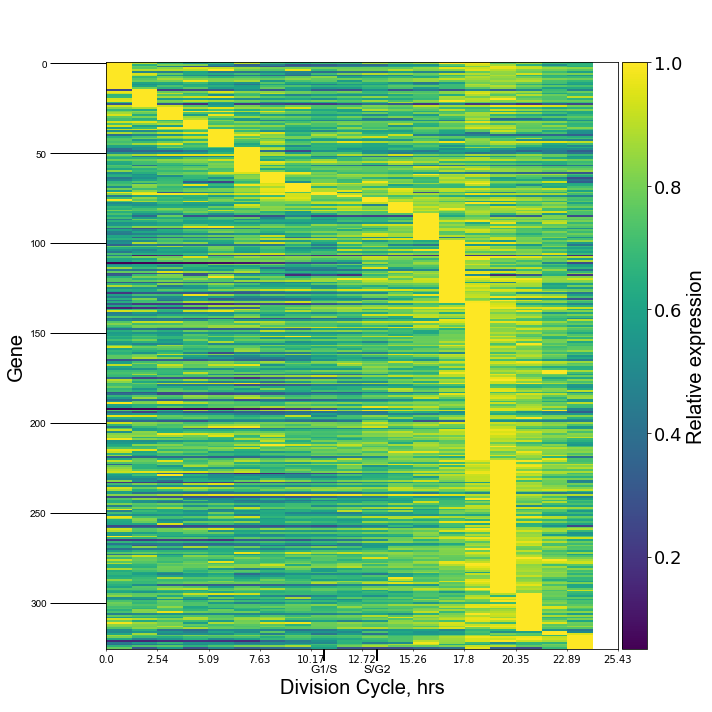

('ENSG00000091651', 'orc6')
number of observations: 249
time of peak expression: 0.3157894736842105
('ENSG00000169740', 'znf32')
number of observations: 363
time of peak expression: 0.21052631578947367
('ENSG00000105173', 'ccne1')
number of observations: 240
time of peak expression: 0.2631578947368421
('ENSG00000162999', 'dusp19')
number of observations: 153
time of peak expression: 0.21052631578947367
('ENSG00000123607', 'ttc21b')
number of observations: 131
time of peak expression: 0.7894736842105263
('ENSG00000173599', 'pc')
number of observations: 215
time of peak expression: 0.7894736842105263
('ENSG00000134057', 'ccnb1')
number of observations: 281
time of peak expression: 0.7894736842105263
('ENSG00000178999', 'aurkb')
number of observations: 303
time of peak expression: 0.7368421052631579
('ENSG00000156970', 'bub1b')
number of observations: 223
time of peak expression: 0.7368421052631579
('ENSG00000167065', 'dusp18')
number of observations: 221
time of peak expression: 0.736842

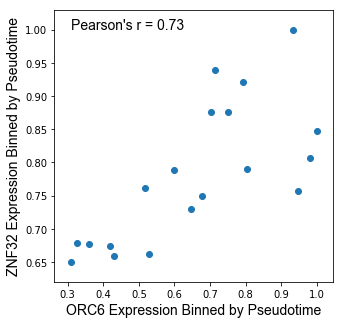

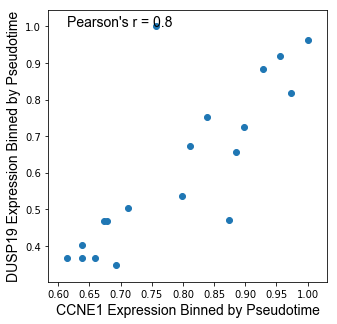

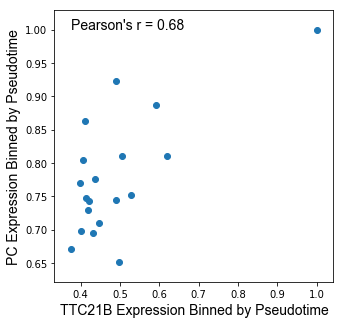

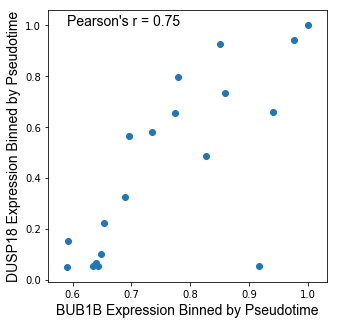

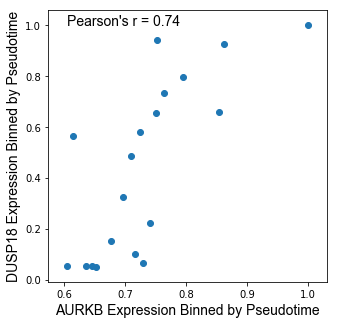

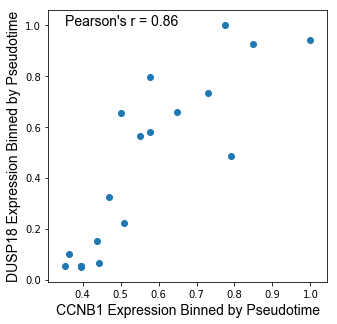

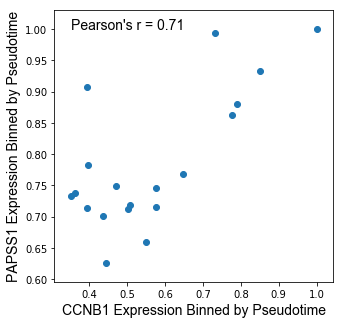

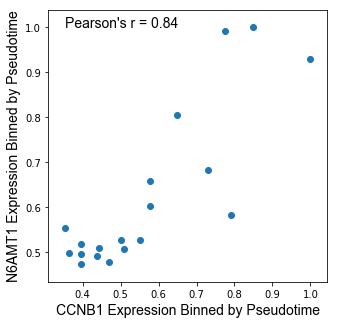

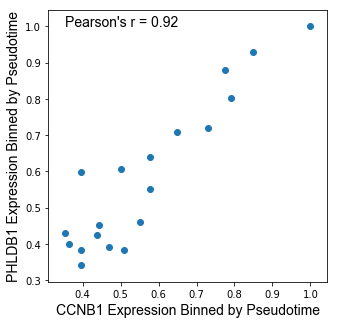

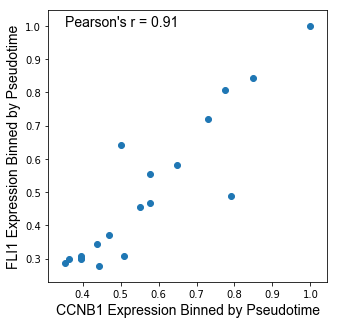

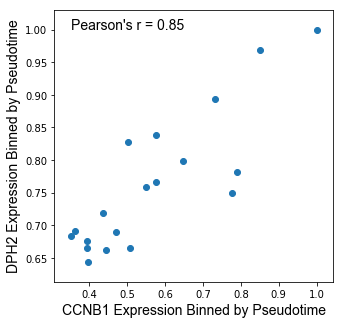

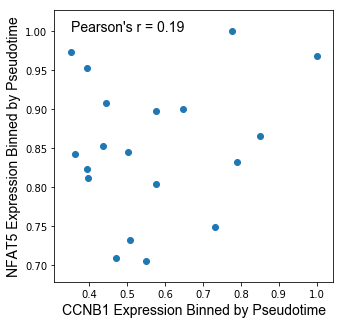

correlation of ORC6 and ZNF32: 0.7255029527680241
correlation of CCNE1 and DUSP19: 0.8028439342636496
correlation of TTC21B and PC: 0.6812528032180198

correlation of bub1b_dusp18: 0.7497485918889091
correlation of aurkb_dusp18: 0.7417701413831694
correlation of ccnb1_papss1: 0.7121442602217425
correlation of ccnb1_n6amt1: 0.8415638580786049
correlation of ccnb1_phldb1: 0.923338684035998
correlation of ccnb1_fli1: 0.9104268054143063
correlation of ccnb1_dph2: 0.853099360538988


In [26]:
#%% Idea: Make temporal heatmap for peak protein expression, and compare known and novel proteins that peak at similar times
# Execution: plt.imshow makes a heatmap if given a 2D array
# Output: heatmap; correlations of known/novel proteins
highlights = []#'ORC6','DUSP19','BUB1B','DPH2', 'FLI1']
highlights_ensg = []#'ORC6','DUSP19','BUB1B','DPH2', 'FLI1']

protein_heatmap_results = TemporalDelay.protein_heatmap(highlights, highlights_ensg, 
    ccd_comp, u_well_plates, wp_ensg, pol_sort_norm_rev, pol_sort_well_plate, pol_sort_ab_cell, pol_sort_ab_nuc, pol_sort_ab_cyto, pol_sort_mt_cell, wp_iscell, wp_isnuc, wp_iscyto)
sorted_maxpol_array, wp_binned_values, wp_max_pol, wp_max_pol_ccd, xvals = protein_heatmap_results

# Correlations of known and novel proteins that peak at similar times
TemporalDelay.peak_expression_correlation_analysis(wp_binned_values, wp_max_pol, wp_ensg, pol_sort_well_plate, u_well_plates)


reading scRNA-Seq data
filtering for biotype: protein_coding


Trying to set attribute `.obs` of view, making a copy.


data shape: (1152, 19997)
data shape after filtering: (1021, 13450)
finished reading scRNA-Seq data


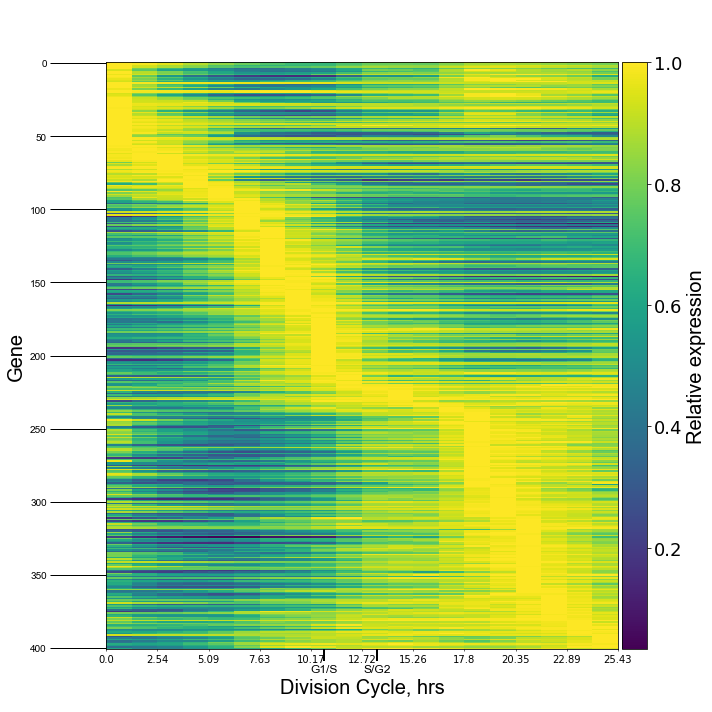

In [27]:
#%% Create a heatmap of peak RNA expression
highlight_names, highlight_ensg = [],[]
adata, sorted_max_moving_avg_pol_ccd, norm_exp_sort, max_moving_avg_pol = TemporalDelay.rna_heatmap(highlight_names, highlight_ensg, ccdtranscript, xvals)


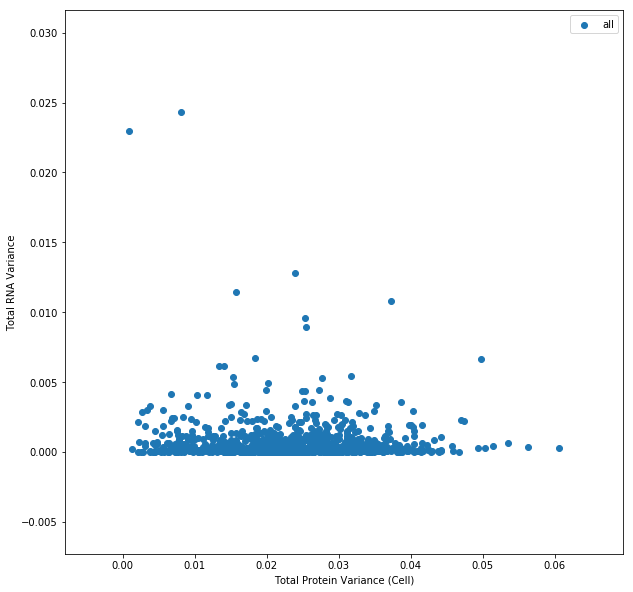

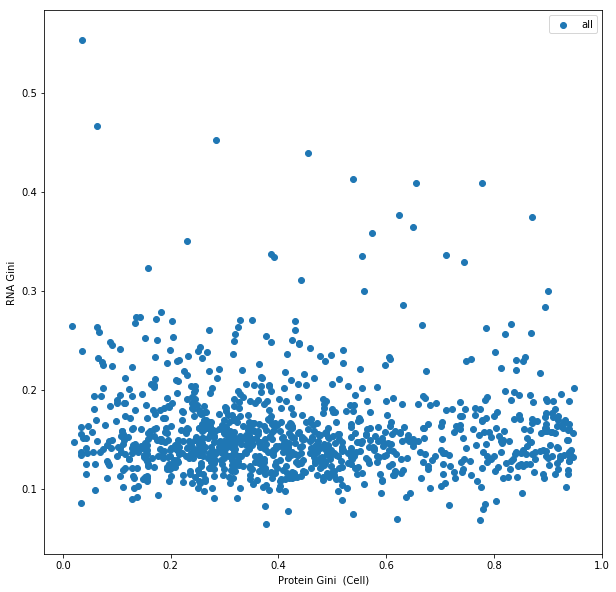

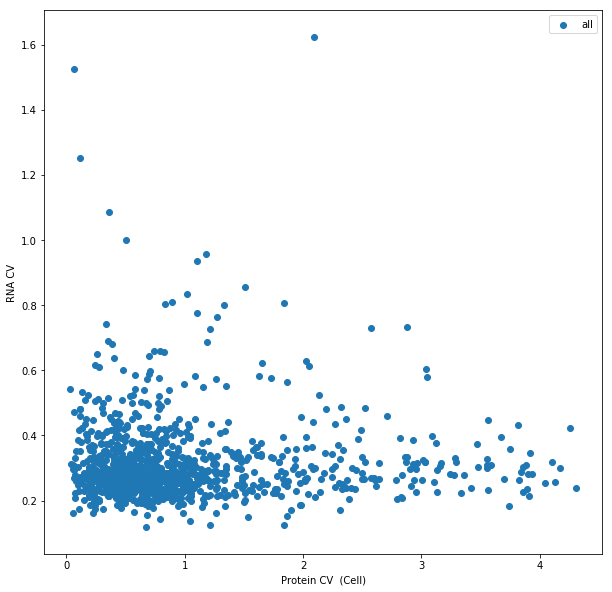

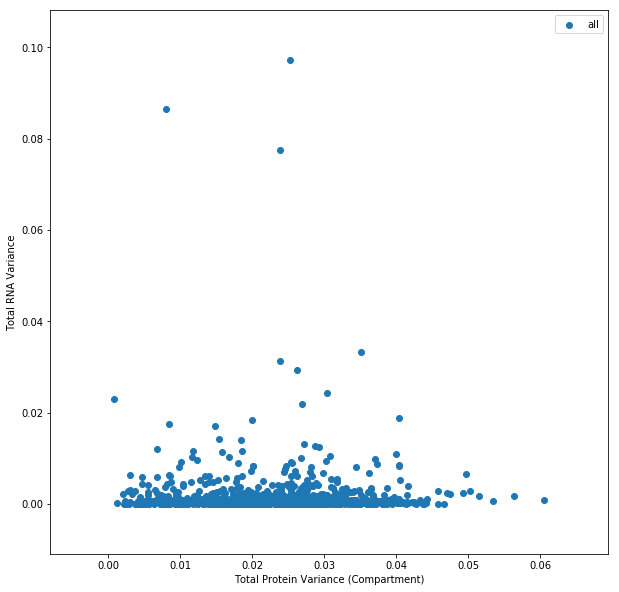

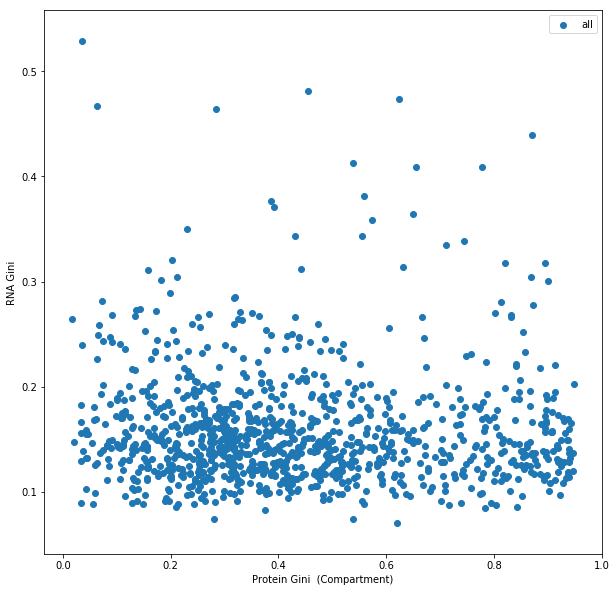

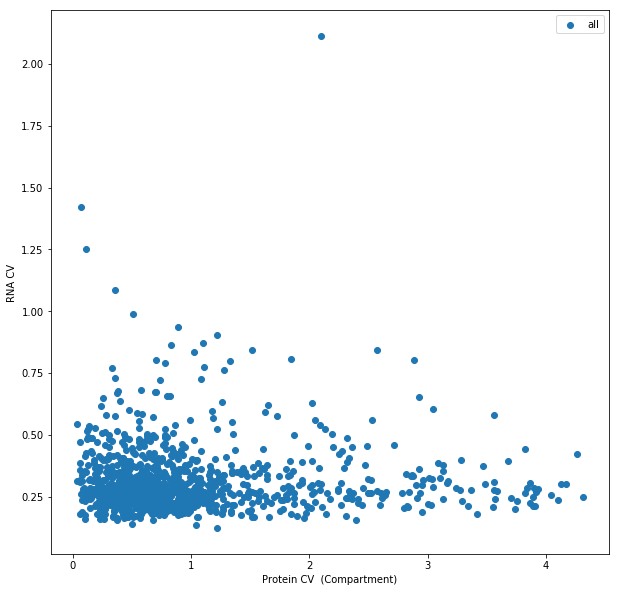

The name arrays are the same: True


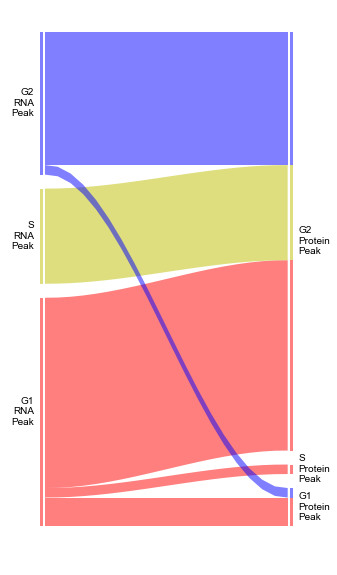

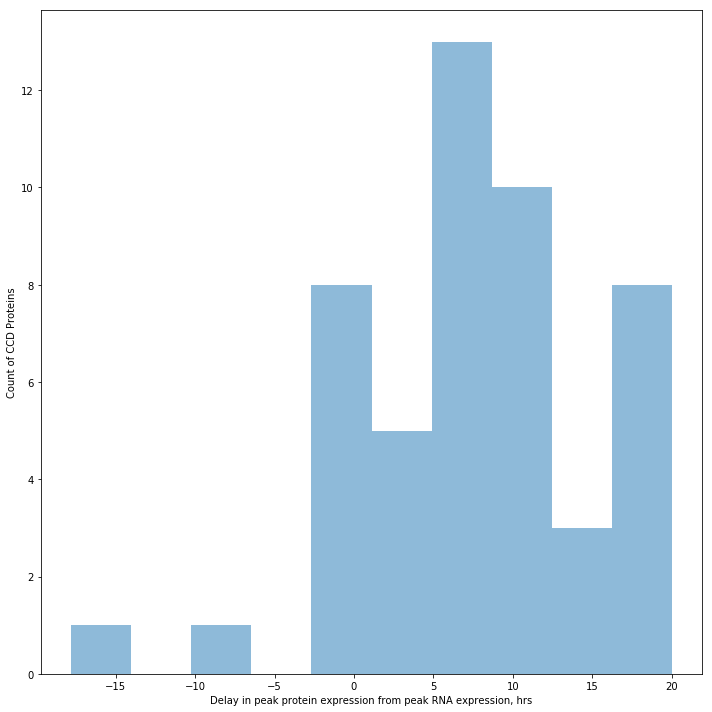

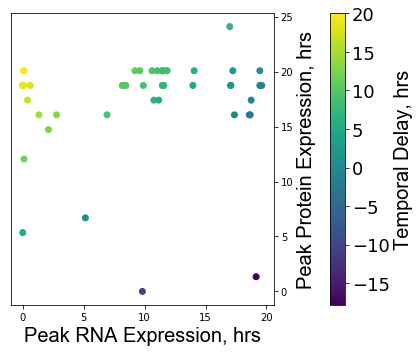

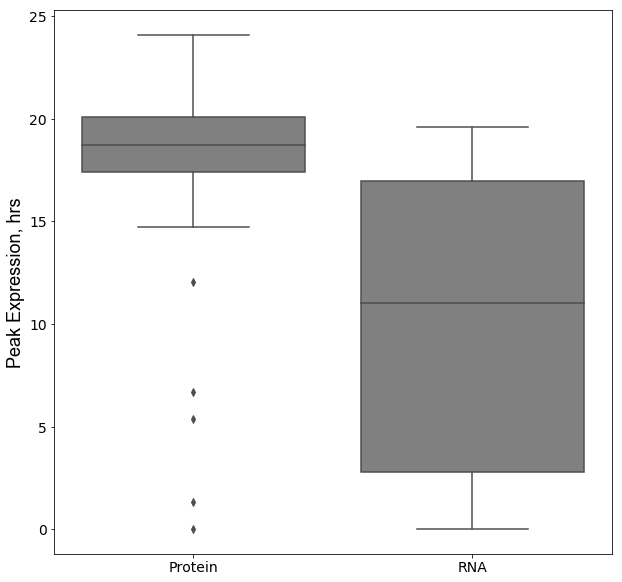

Count of prot CCD genes: 326
Count of CCD RNA genes: 401
Count of intersection betweeen CCD prot and CCD RNA: 49
Median delay of RNA and protein expression time for CCD proteins: 8.557535210526318
Median RNA expression time for CCD proteins: 11.037922
Median protein expression time for CCD proteins: 18.740105263157893
One-sided kruskal for median protein expression time higher than median RNA expression time: 2.2860711463550264e-08
One-sided, one-sample t-test for mean delay in protein expression larger than zero: 4.9107641634443646e-08
--- temporal delay

significant delay in peak protein expression compared to transcript expression, 8.557535210526318 hours on average

G1 is the longest period of the cell cycle, in which the majority of RNAs (43.64089775561097%) peak in expression

However, the majority (75.70093457943925%) of the proteins peaked towards the end of the cell cycle corresponding to the S&G2 phases

The delay between peak RNA and protein expression for the 50 CCD protein

C:\Users\antho\Documents\Projects\CellCycle\FucciRNA\SingleCellProteogenomics\TemporalDelay.py:435: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  duplicated_ensg_peaked_after_g1 = np.array([sum(peaked_after_g1_prot[wp_ensg[ccd_comp] == ensg]) for ensg in duplicated_ensg_ccd])


In [28]:
#%% Compare the variances and time of peak expression between protein and RNA
TemporalDelay.compare_variances_prot_v_rna(adata, norm_exp_sort, wp_ensg, var_comp_prot, gini_comp_prot, cv_comp_prot, var_cell_prot, gini_cell_prot, cv_cell_prot)
TemporalDelay.compare_peak_expression_prot_v_rna(adata, wp_ensg, ccd_comp, ccdtranscript, wp_max_pol, wp_max_pol_ccd, sorted_maxpol_array, max_moving_avg_pol, sorted_max_moving_avg_pol_ccd)


## Protein PTM analysis using PTM site occupancies
Investigation of the properties of proteins with different cell cycle regulation using PTMs and stability measurements
-  PTMs are observed using previously published bulk and phospho-enriched mass spectrometry (MS) proteomic data
-  Differences in PTM regulation is inferred using PTM occupancy for each PTM site
-  Protein stability was measured by MS thermal profiling in an external study
-  Differences in thermal shifts indicate different stabilities and propensity for unfolding

In [29]:
#%% Import the genes names we're analyzing
# Read in RNA-Seq data again and the CCD gene lists
valuetype, use_spikeins, biotype_to_use = "Tpms", False, "protein_coding"
adata, phases = RNADataPreparation.read_counts_and_phases(valuetype, use_spikeins, biotype_to_use)
adata, phasesfilt = RNADataPreparation.qc_filtering(adata, do_log_normalize= True, do_remove_blob=True)

import_dict = Loaders.load_ptm_and_stability(adata)
wp_ensg, wp_max_pol = import_dict["wp_ensg"], import_dict["wp_max_pol"]
ccdtranscript, nonccdtranscript = import_dict["ccdtranscript_names"], import_dict["nonccdtranscript_names"]
ccdprotein_transcript_regulated, ccdprotein_nontranscript_regulated = import_dict["ccdprotein_transcript_regulated_names"], import_dict["ccdprotein_nontranscript_regulated_names"]
genes_analyzed = import_dict["genes_analyzed_names"]
ccd_regev_filtered, ccd_filtered = import_dict["ccd_regev_filtered_names"], import_dict["ccd_filtered_names"] 
ccdprotein, nonccdprotein = import_dict["ccdprotein_names"], import_dict["nonccdprotein_names"]
utils.save_gene_names_by_category(adata) # We're using gene names for this analysis instead of ENSG gene identifiers, so save those gene names


filtering for biotype: protein_coding


Trying to set attribute `.obs` of view, making a copy.


data shape: (1152, 19997)
data shape after filtering: (1021, 13450)


Loading input/raw/U2OSBulkAllProteinGroups.tsv ...
9848 proteins
2573 modified proteins (26.13%)
292: number of all transcript regulated CCD genes of 401 detected.
65: number of transcript regulated CCD genes from Diana's study of 72 detected.
241: number of non-transcript regulated CCD genes from Diana's study of 409 detected.
7324: number of proteins of 13440 detected.
0.18049959709911362: median coverage for all proteins
0.4350121423292155: median coverage for modified proteins
Loading input/raw/U2OSPhosphoAllProteinGroups.tsv ...
11228 proteins
11057 modified proteins (98.48%)
284: number of all transcript regulated CCD genes of 401 detected.
66: number of transcript regulated CCD genes from Diana's study of 72 detected.
242: number of non-transcript regulated CCD genes from Diana's study of 409 detected.
7015: number of proteins of 13440 detected.
0.29385964912280704: median coverage for all proteins
0.3230858626053612: median coverage for modified proteins


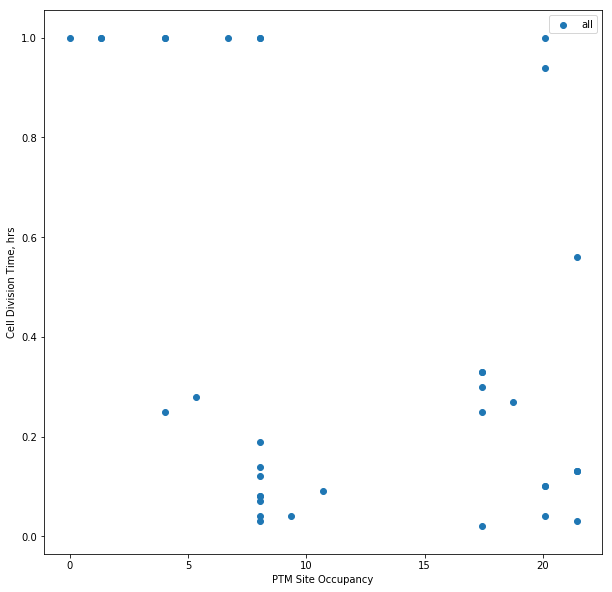

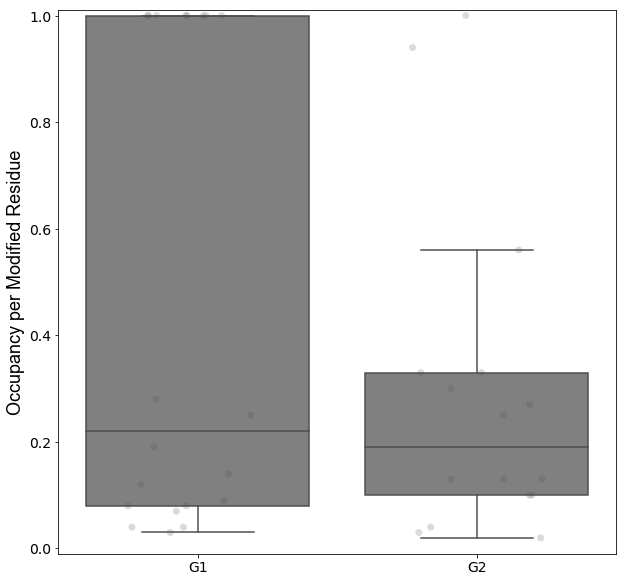

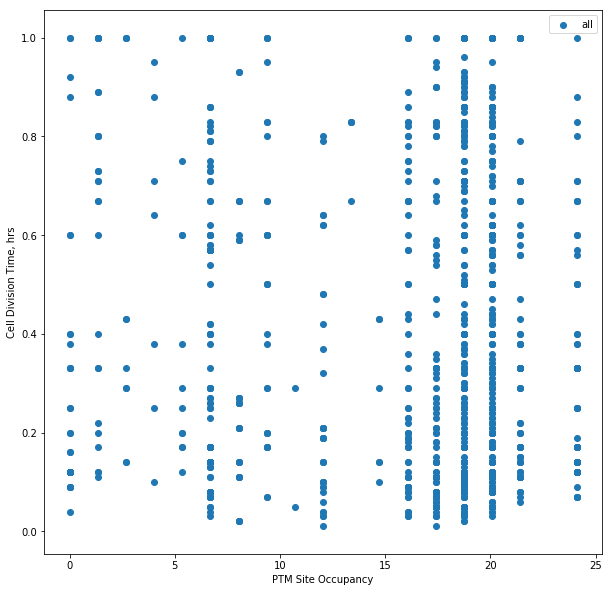

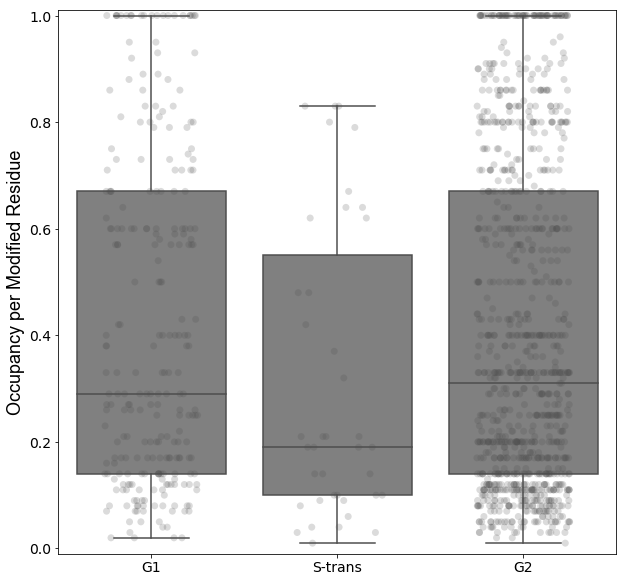

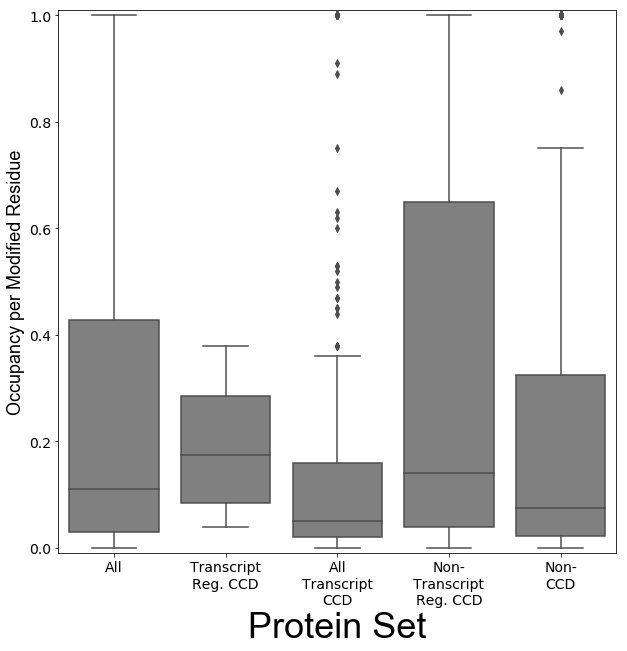

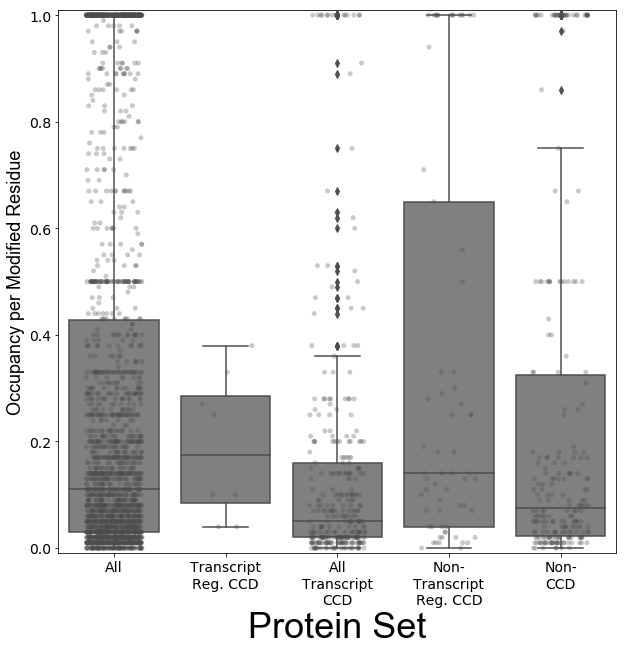

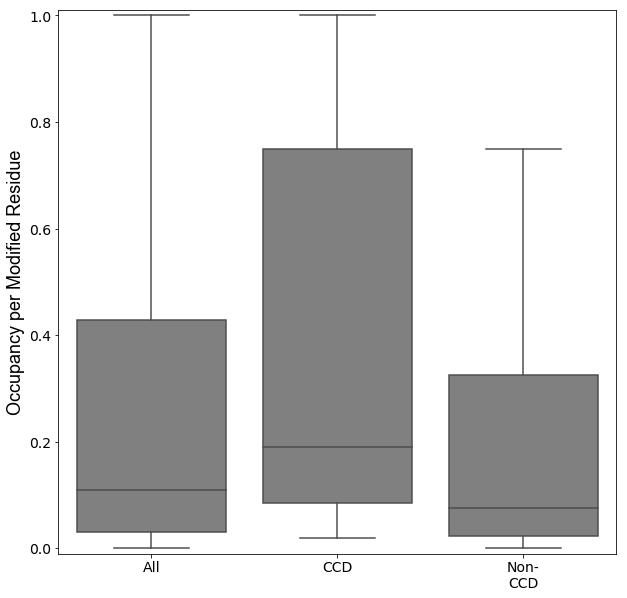

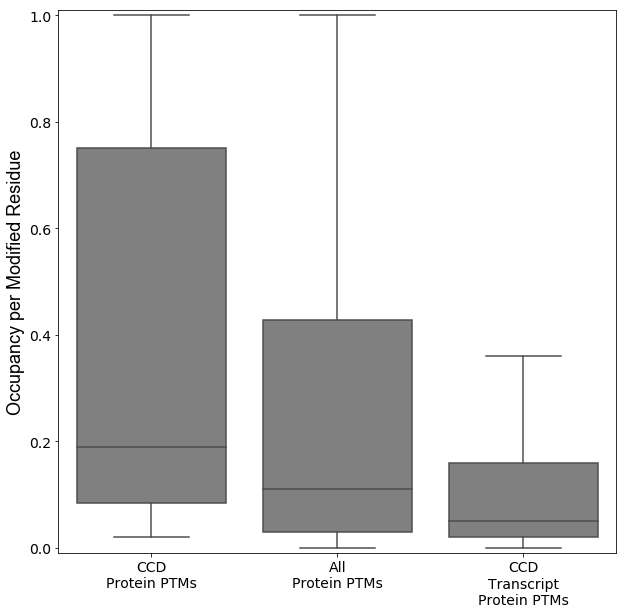

OCCUPANCY PER MODIFIED BASE
Note: I excluded artifact modifications and required there to be

mean occupancy per modified residue for all proteins: 0.2895240032546771
mean occupancy per modified residue for all transcriptionally regulated CCD: 0.14803076923076944
mean occupancy per modified residue for Diana's transcriptionally regulated CCD: 0.18875
mean occupancy per modified residue for Diana's non-transcriptionally regulated CCD: 0.3486153846153846
two-sided t-test for same means of transcript and non-transcriptionally regulated: 0.2511654046921914
two-sided t-test for same means of all and non-transcriptionally regulated: 0.4298200322936512
two-sided t-test for same means of all and non-transcriptionally regulated: 0.4298200322936512
two-sided t-test for same means of all and non-transcriptionally regulated: 0.4298200322936512

median occupancy per modified residue for all proteins: 0.11
median occupancy per modified residue for all transcriptionally regulated CCD: 0.05
median occ

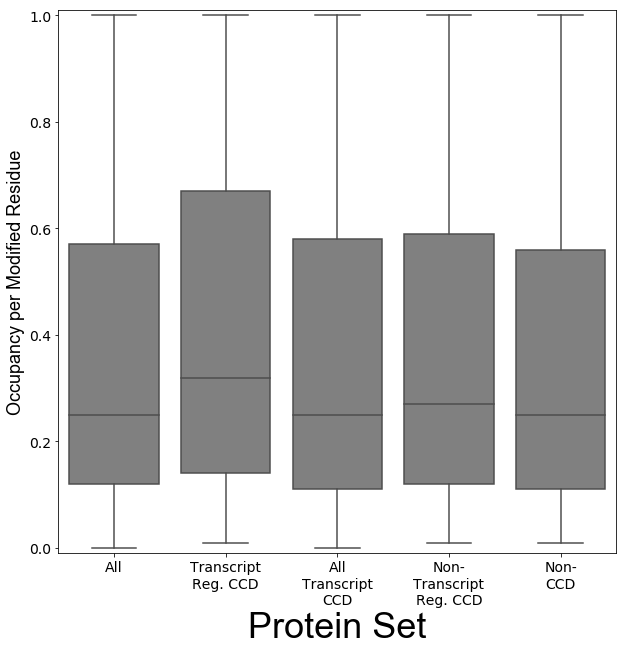

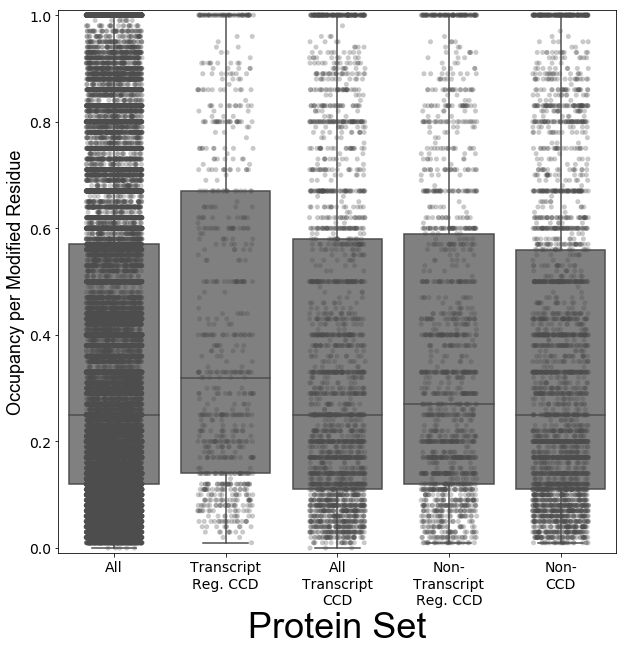

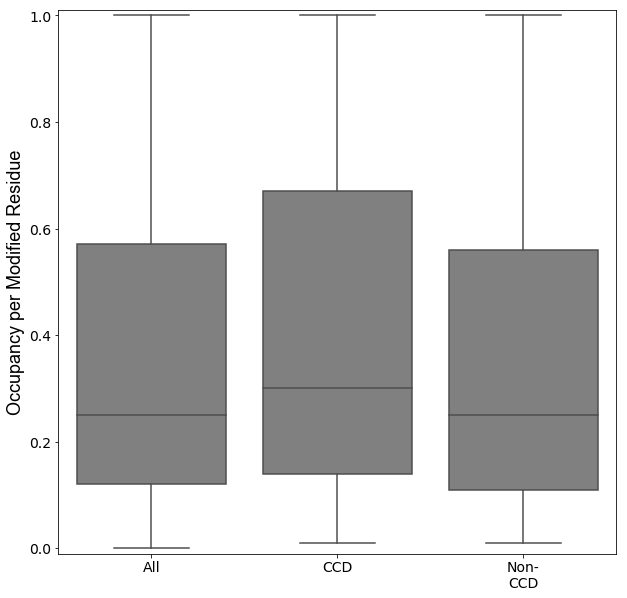

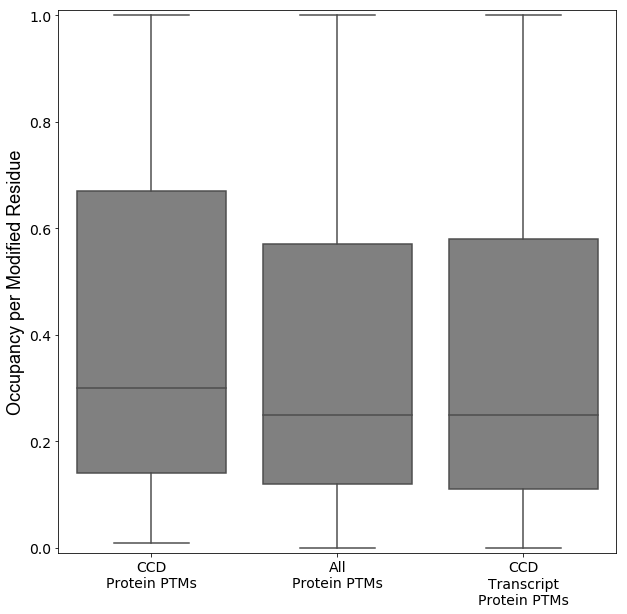

OCCUPANCY PER MODIFIED BASE
Note: I excluded artifact modifications and required there to be

mean occupancy per modified residue for all proteins: 0.3549518295916781
mean occupancy per modified residue for all transcriptionally regulated CCD: 0.3554267371601199
mean occupancy per modified residue for Diana's transcriptionally regulated CCD: 0.4141221374045803
mean occupancy per modified residue for Diana's non-transcriptionally regulated CCD: 0.3666706803130641
two-sided t-test for same means of transcript and non-transcriptionally regulated: 0.00023803213361829113
two-sided t-test for same means of all and non-transcriptionally regulated: 2.0142692668464623e-08
two-sided t-test for same means of all and non-transcriptionally regulated: 2.0142692668464623e-08
two-sided t-test for same means of all and non-transcriptionally regulated: 2.0142692668464623e-08

median occupancy per modified residue for all proteins: 0.25
median occupancy per modified residue for all transcriptionally regu

In [30]:
#%% Analyze the PTMs from bulk U2OS data and see if they are more expressed
# one or the other
# Idea: PTM annotation counts are pretty biased; PTM data might be better
# Execution: 
#   Take in the results from analyzing U2OS data with MetaMorpheus.
#   Count mods for each protein, excluding oxidations
# Output: # of PTMs per protein in each class and for all proteins

# Read in MetaMorpheus results
genemodsBulk = PTMAnalysis.analyze_ptms("input/raw/U2OSBulkAllProteinGroups.tsv", ccdtranscript, ccdprotein_transcript_regulated, ccdprotein_nontranscript_regulated, genes_analyzed)
genemodsPhospho = PTMAnalysis.analyze_ptms("input/raw/U2OSPhosphoAllProteinGroups.tsv", ccdtranscript, ccdprotein_transcript_regulated, ccdprotein_nontranscript_regulated, genes_analyzed)

# Analyze the modification occupancy for each PTM site
dfBulk, occdfBulk = PTMAnalysis.process_genemods(genemodsBulk)
dfPhospho, occdfPhospho = PTMAnalysis.process_genemods(genemodsPhospho)

# Investigate whether PTM occupancies have correlations with cell division pseudotime (they don't with this dataset)
PTMAnalysis.temporal_ptm_regulation_not_observed(dfBulk, occdfBulk, "Bulk", wp_max_pol, wp_ensg, ccdprotein)
PTMAnalysis.temporal_ptm_regulation_not_observed(dfPhospho, occdfPhospho, "Phospho", wp_max_pol, wp_ensg, ccdprotein)

# Compare the PTM regulation using PTM site occupancies between transcript and non-transcript regulated groups
PTMAnalysis.compare_ptm_regulation(dfBulk, occdfBulk, "Bulk", genes_analyzed, ccd_regev_filtered, ccdtranscript, nonccdtranscript, ccdprotein_transcript_regulated, ccdprotein_nontranscript_regulated, ccdprotein, nonccdprotein)
PTMAnalysis.compare_ptm_regulation(dfPhospho, occdfPhospho, "Phospho", genes_analyzed, ccd_regev_filtered, ccdtranscript, nonccdtranscript, ccdprotein_transcript_regulated, ccdprotein_nontranscript_regulated, ccdprotein, nonccdprotein)


## Protein stability analysis using MS proteomic melting point data

C:\Users\antho\Documents\Projects\CellCycle\FucciRNA\SingleCellProteogenomics\ProteinStabilityAnalysis.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_groups[iii].extend(ccd_stab[notna]["Melting point [°C]"])
C:\Users\antho\Documents\Projects\CellCycle\FucciRNA\SingleCellProteogenomics\ProteinStabilityAnalysis.py:129: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  name_groups[iii].extend(ccd_stab[notna]["ProteinName"])


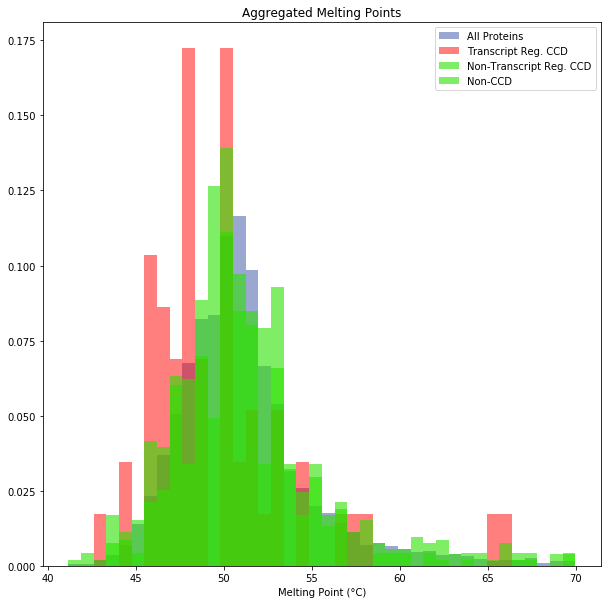

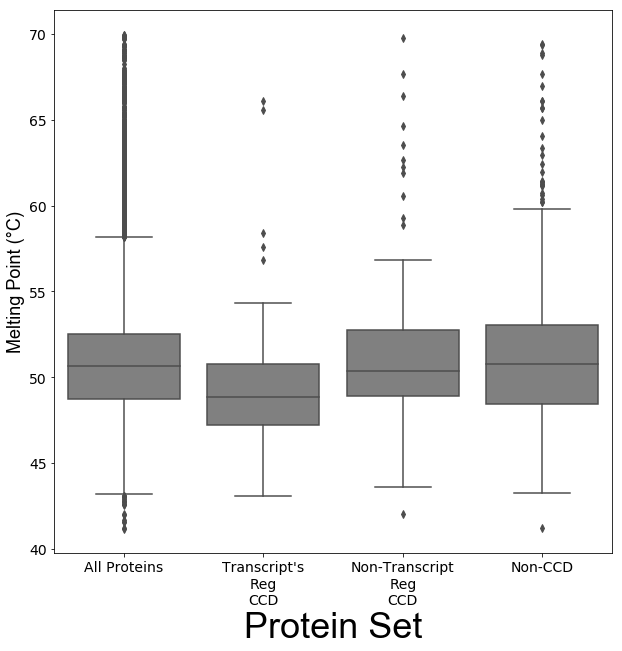

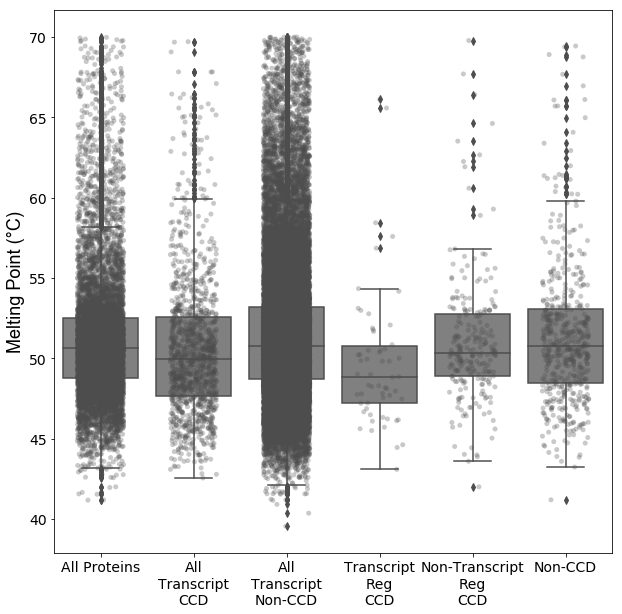

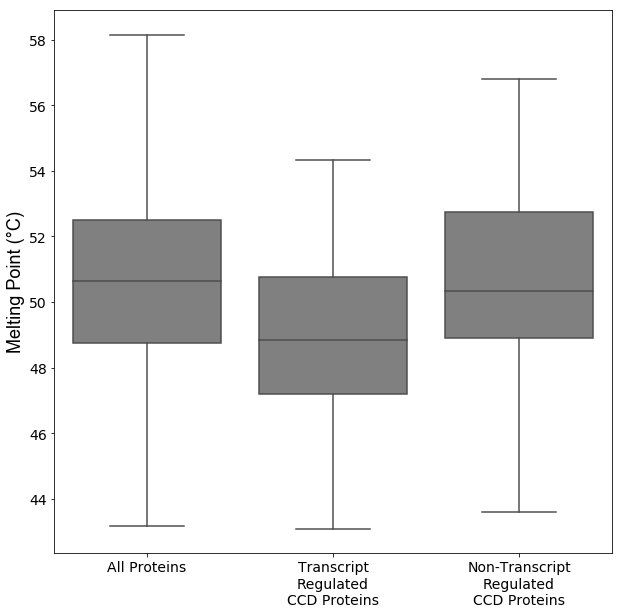

Aggregated Melting Points statistical tests
Testing whether transcript reg. CCD melting points are different than non-transcript reg. CCD
49.77741379310344 +/- 4.348234009478912: Transcript Reg. CCD (mean, std)
51.00116033755274 +/- 3.8711133255634813: Non-Transcript Reg. CCD (mean, std)
48.84: Transcript Reg. CCD (median)
50.34: Non-Transcript Reg. CCD (median)
Ttest_indResult(statistic=-2.097301618534003, pvalue=0.036823671226393434): two sided t-test
KruskalResult(statistic=10.401764341477996, pvalue=0.001258949668986527): two sided kruskal

Testing whether non-transcript reg. CCD is different than all proteins
51.16160828025478 +/- 3.9038870389561042: All Proteins (mean, std)
51.00116033755274 +/- 3.8711133255634813: Non-Transcript Reg. CCD (mean, std)
50.64: All Proteins (median)
50.34: Non-Transcript Reg. CCD (median)
Ttest_indResult(statistic=0.6247084213155317, pvalue=0.5321777033894367): two sided t-test
KruskalResult(statistic=0.349307483084615, pvalue=0.5545054090918851): tw

In [31]:
#%% Perform melting point analysis
# Idea: A lower melting point for a protein indicates a higher propensity to unfold, 
#    and so the melting points measured by MS proteomics serve as a useful way to study the protein stability of CCD proteins
# Output: Boxplots illustrating differences in stability for different classes of CCD proteins
ProteinStabilityAnalysis.melting_point_analysis(ccdtranscript, nonccdtranscript, ccdprotein_transcript_regulated, ccdprotein_nontranscript_regulated, nonccdprotein)
